# INTRODUCCIÓN

El servicio de venta de autos usados Rusty Bargain está desarrollando una aplicación para atraer nuevos clientes. Gracias a esa app, se puede saber rápidamente el valor de mercado de tu coche. Se tiene acceso al historial: especificaciones técnicas, versiones de equipamiento y precios.

Se va a crear un modelo que determine el valor del mercado de los mismos
A Rusty Bargain le interesa:
- la calidad de la predicción;
- la velocidad de la predicción;
- el tiempo requerido para el entrenamiento

## Preparación de datos

In [1]:
#Librerías Necesarias
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [2]:
#Importando y checando información del DataFrame y su estadística descriptiva
df = pd.read_csv("dataset/car_data.csv")

print(df.info())
print()
print('Estadística descriptiva de DataFrame:')
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

De lo explorado anteriormente, se tiene lo siguiente:
- Columnas con letras Mayus/Minus mezcladas. Hay que separar entre palabras con guión bajo.

- Cambiar tipo de datos que sean necesario.

- Columna NumberOfPictures al poseer valores cero (min=0, max=0), puede ser eliminada.

Además:

- Price tiene valores de 0 a 20000.
- Power tiene valores de 0 a 20000.
- RegistrationYear tiene valores de 0 a 9999.
- RegistrationMonth tiene valores de 0 a 12. Siendo que sólo son 12 meses lo que tiene un año. Estos vaalores se tratarán algunas celdas más abajo.

In [3]:
#Cambiando formato de columnas para una mejor exploración de datos
df.columns = df.columns.str.replace(r'([A-Z])', r'_\1', regex=True).str.strip('_').str.lower()
print(df.columns)#mostrando cambios

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'mileage', 'registration_month', 'fuel_type', 'brand',
       'not_repaired', 'date_created', 'number_of_pictures', 'postal_code',
       'last_seen'],
      dtype='object')


In [4]:
#Cambiando tipo de datos
date_col = df[['date_crawled', 'date_created', 'last_seen']]
category_col = df[['vehicle_type', 'fuel_type', 'gearbox']]
for col in date_col:
    df[col] = pd.to_datetime(df[col], format= '%d/%m/%Y %H:%M')
    
for col in category_col:
    df[col] = df[col].astype('category')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        316879 non-null  category      
 3   registration_year   354369 non-null  int64         
 4   gearbox             334536 non-null  category      
 5   power               354369 non-null  int64         
 6   model               334664 non-null  object        
 7   mileage             354369 non-null  int64         
 8   registration_month  354369 non-null  int64         
 9   fuel_type           321474 non-null  category      
 10  brand               354369 non-null  object        
 11  not_repaired        283215 non-null  object        
 12  date_created        354369 non-null  datetime64[ns]
 13  number_of_pictures  354369 no

In [5]:
#Eliminando columnas no necesarias
df_new = df.drop(['number_of_pictures','date_crawled', 'date_created', 'last_seen', 'postal_code'], axis=1)
print(df_new.columns)#observando cambios

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'mileage', 'registration_month', 'fuel_type', 'brand',
       'not_repaired'],
      dtype='object')


Las columnas date_crawled, date_created, last_seen y postal_code tambien se han eliminado debido a que las mismas son fechas que no tienen relación alguna con el objetivo solicitado, esto es, el precio o su valor en el mercado.

In [6]:
#Checando existencia de valores ausentes y duplicados
print(df_new.isna().sum())
print()
print('Valores duplicado:', df_new.duplicated().sum())

price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
mileage                   0
registration_month        0
fuel_type             32895
brand                     0
not_repaired          71154
dtype: int64

Valores duplicado: 27543


Más adelante se verá si se rellenan los valores ausentes con la moda (para categóricos) y la mediana (para númericos) o si se eliminaran los mismos.

In [7]:
#Tratando valores duplicados
#Chequeamos la duplicidad de los mismos para saber si eliminarlos o no
dup_row = df_new[df_new.duplicated(keep=False)]
#keep=False asegura que todas las instancias duplicadas se marquen, no solo las adicionales.

print(f'Total de registros duplicados: {len(dup_row)}')

dup_row_sorted = dup_row.sort_values(list(df_new.columns))
#Muestro filas duplicadas
print(dup_row_sorted)

Total de registros duplicados: 49086
        price vehicle_type  registration_year gearbox  power        model  \
199835      0          bus               1994  manual      0  transporter   
283241      0          bus               1994  manual      0  transporter   
82258       0          bus               1994  manual     68  transporter   
254668      0          bus               1994  manual     68  transporter   
107497      0          bus               1995  manual    102  transporter   
...       ...          ...                ...     ...    ...          ...   
320429  20000        sedan               2011    auto    265     c_klasse   
320559  20000        sedan               2011    auto    265     c_klasse   
321365  20000        sedan               2011    auto    265     c_klasse   
142818  20000          suv               2011  manual    150       tiguan   
143161  20000          suv               2011  manual    150       tiguan   

        mileage  registration_month fu

Debido a lo mostrado anteriormente, se ha decidido eliminar los duplicados del DataFrame, pues en un pequeño análisis se pudo observar los duplicados explicitos de este. El mismo repetía datos ya existentes.

In [8]:
#Eliminando duplicados
df_new.drop_duplicates(inplace= True)
#Muestro la existencia de los cambios
print(f'Valores duplicados: {df_new.duplicated().sum()}')

Valores duplicados: 0


Antes de tratar los valores ausentes se trabajaran datos de dudosa información (atípicos) teniendo en cuenta los objetivos de Rusty Bargain. Tales datos se pueden observar en la columna 'registration_year', 'power' y 'registration_month'

In [9]:
#Mostrando estadísticas descriptivas luego de eliminación de duplicados
print('Estadística descriptiva luego de eliminación de duplicados:')
print(df_new.describe())

Estadística descriptiva luego de eliminación de duplicados:
               price  registration_year          power        mileage  \
count  326826.000000      326826.000000  326826.000000  326826.000000   
mean     4403.747330        2004.230985     110.244705  128144.073605   
std      4518.209808          91.120018     195.886373   37947.663920   
min         0.000000        1000.000000       0.000000    5000.000000   
25%      1000.000000        1999.000000      69.000000  125000.000000   
50%      2700.000000        2003.000000     105.000000  150000.000000   
75%      6350.000000        2008.000000     141.000000  150000.000000   
max     20000.000000        9999.000000   20000.000000  150000.000000   

       registration_month  
count       326826.000000  
mean             5.696239  
std              3.724122  
min              0.000000  
25%              3.000000  
50%              6.000000  
75%              9.000000  
max             12.000000  


## Visualizando Datos

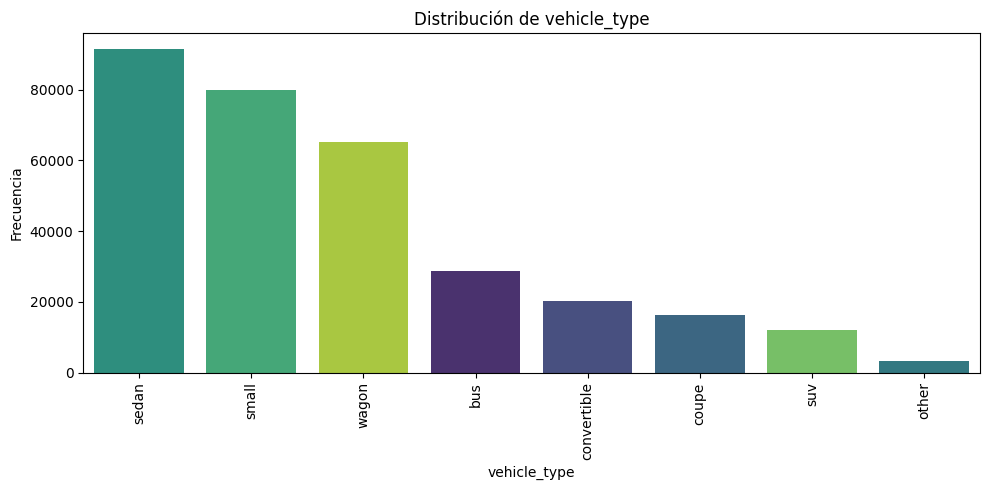

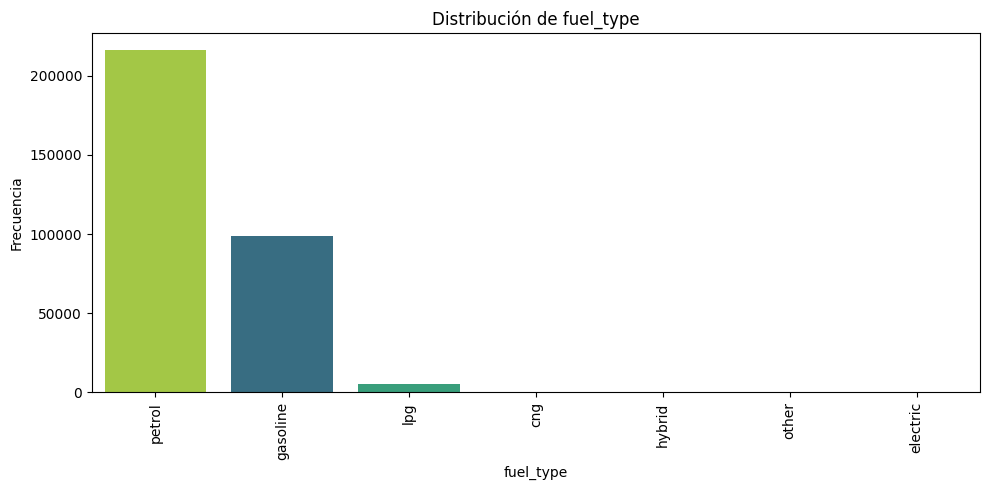

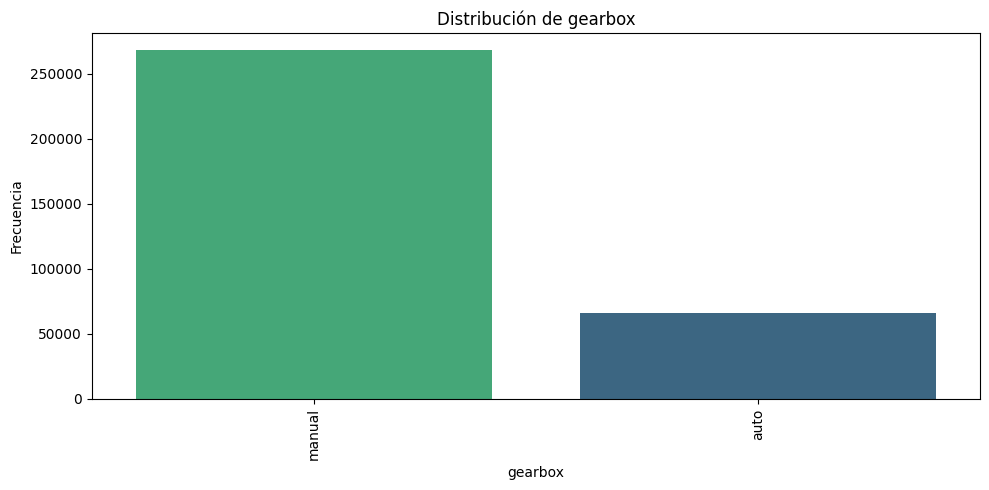

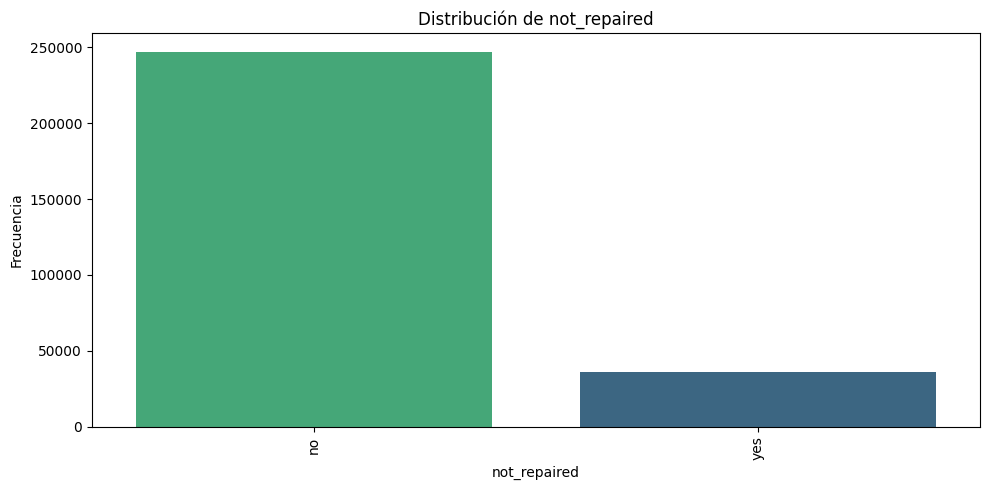

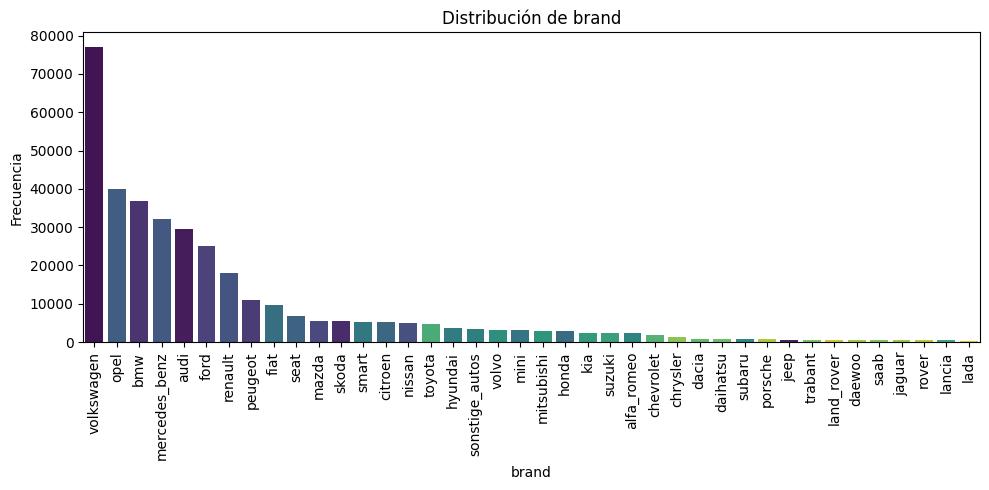

In [10]:
#Distribución de columnas categóricas
categorical_columns = ['vehicle_type', 'fuel_type', 'gearbox', 'not_repaired', 'brand']

for col in categorical_columns:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index, hue=col, palette='viridis', legend=False)
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

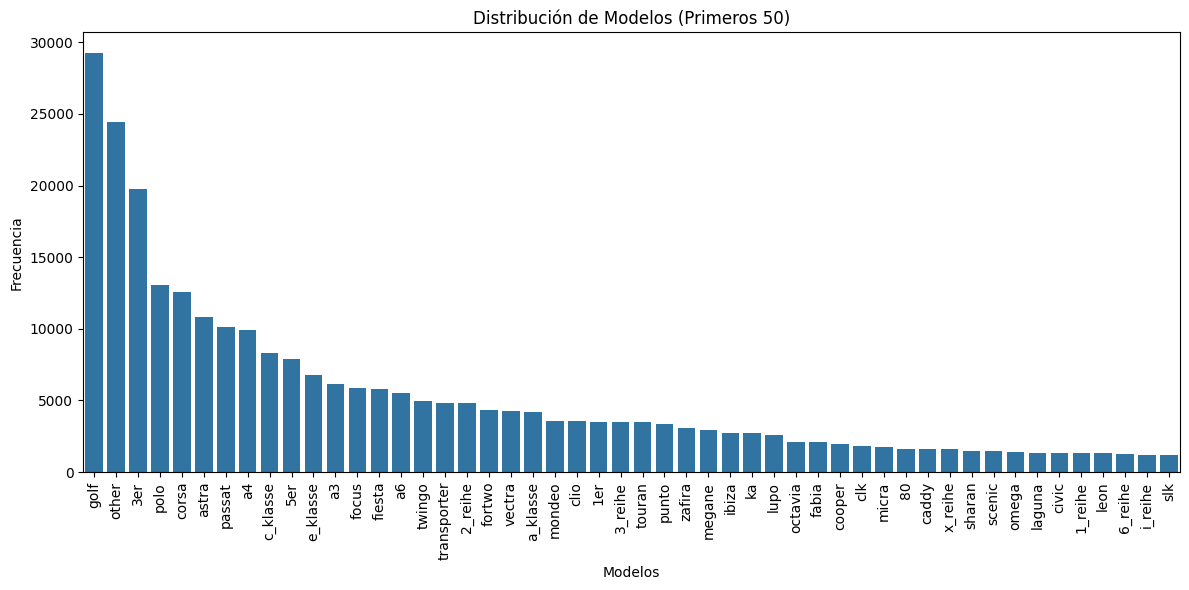

In [11]:
top50_models = df['model'].value_counts().head(50).index
plt.figure(figsize=(12, 6))
sns.countplot(data=df[df['model'].isin(top50_models)], x='model', order=top50_models)
plt.title('Distribución de Modelos (Primeros 50)')
plt.xlabel('Modelos')
plt.ylabel('Frecuencia')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Valores Atípicos

In [12]:
#Observando mínimos y máximos en columna con datos sospechosamente errados
columns = [
    ('registration_year', 'Año'),
    ('power', 'Potencia'),
    ('registration_month', 'Mes')
]

for col, description in columns:
    print(f'{description} más bajo registrado: {df_new[col].min()}')
    print(f'{description} más alto registrado: {df_new[col].max()}')

Año más bajo registrado: 1000
Año más alto registrado: 9999
Potencia más bajo registrado: 0
Potencia más alto registrado: 20000
Mes más bajo registrado: 0
Mes más alto registrado: 12


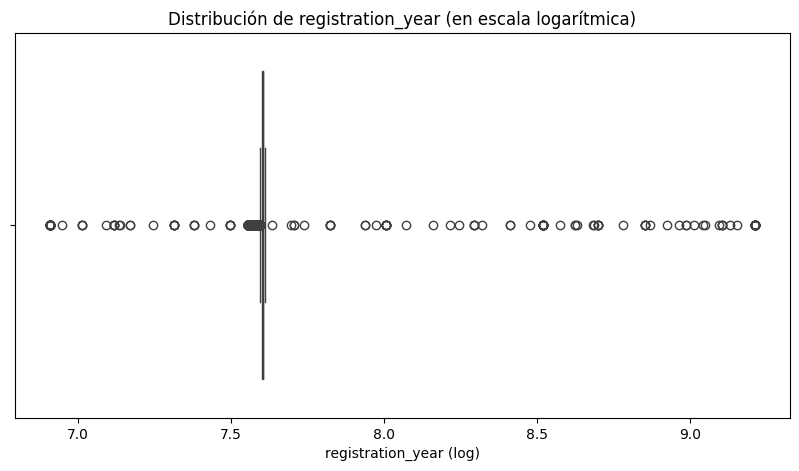

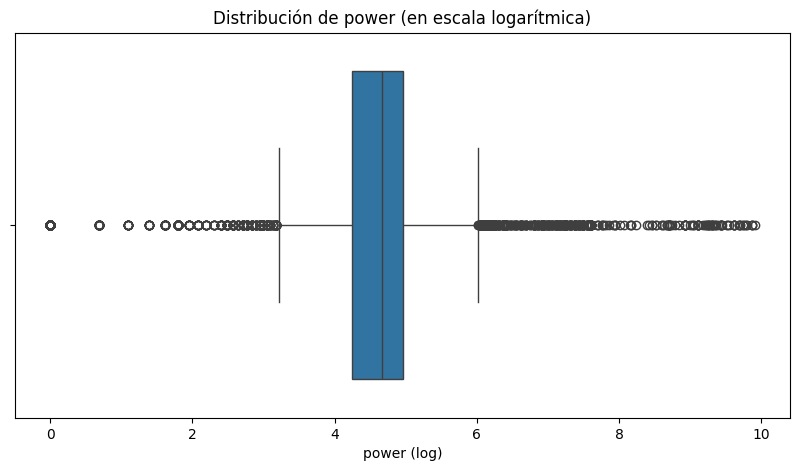

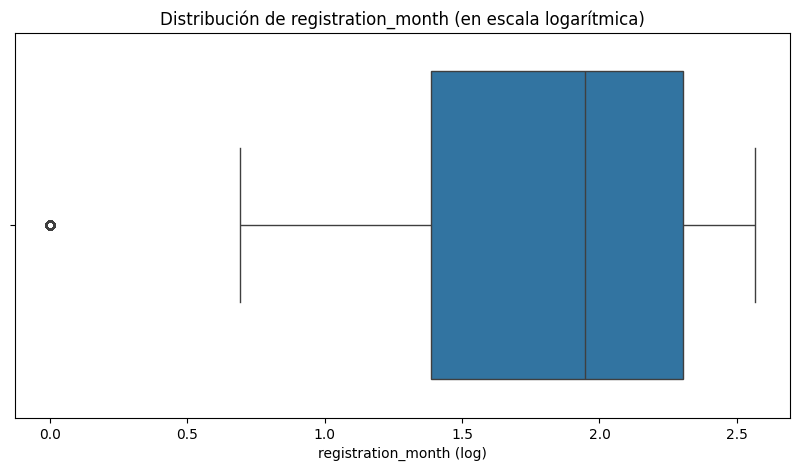

In [13]:
#Diagrama de caja
numeric_columns = ['registration_year', 'power', 'registration_month']
         
for col in numeric_columns:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=np.log1p(df_new[col]))  #np.log1p(x) aplica log(1+x) y evita log(0)
    plt.title(f'Distribución de {col} (en escala logarítmica)')
    plt.xlabel(f'{col} (log)')
    plt.show()

In [14]:
for col in numeric_columns:
    Q1 = df_new[col].quantile(0.25)
    Q3 = df_new[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df_new[(df_new[col] < Q1 - 1.5 * IQR) | (df_new[col] > Q3 + 1.5 * IQR)]
    print(f'{col}: {len(outliers)} valores atípicos detectados.')

outliers_month = df_new[(df_new['registration_month'] < 1)]
print(f"registration_month: {len(outliers_month)} valores atípicos fuera del rango esperado (1-12).")

registration_year: 6040 valores atípicos detectados.
power: 7636 valores atípicos detectados.
registration_month: 0 valores atípicos detectados.
registration_month: 34758 valores atípicos fuera del rango esperado (1-12).


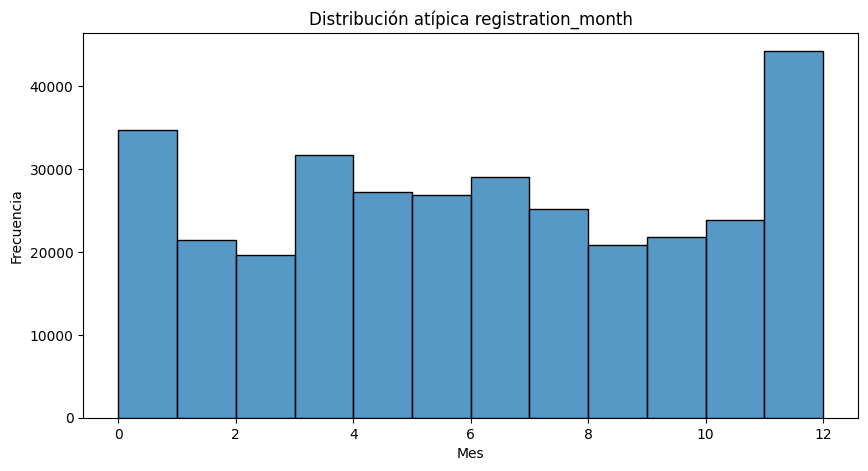

In [15]:
plt.figure(figsize=(10, 5))
sns.histplot(df_new['registration_month'], bins=12, kde=False)
plt.title('Distribución atípica registration_month')
plt.xlabel('Mes')
plt.ylabel('Frecuencia')
plt.show()

- El año más bajo registrado para un automovil en el Dataset es 1000 y el más alto es 9999. Teniendo en cuenta que nos encontramos en el año 2024 y, además, la invención del automovil se remonta a 1886 con el primer vehiculo de tres ruedas impulsado por gasolina, se pueden filtrar tales valores acotandolos entre tales fechas.
Por cuestiones de comodidad y considerando que el auge de las marcas inicia a partir de 1900, el rango a usar en el filtrado de tales datos será (1900, 2024).

- Se tiene además que la potencia mínima de vehiculos registrados en Dataset es de 0. Obviamente, un coche con potencia cero implica un coche, o sin motor o un no-coche(siendo que el mínimo para un auto es de 60CV). Mientras que para la potencia máxima se tiene 20000 CV, como actualmente en el mercado el automovil con mayor potencia es el Lotus Evija (contando con una potencia de 2039CV), esto podría tratarse de un simple error de tipeo. Se verá a continuación.

- Para el mes de registro, se tiene un mínimo de 0 y máximo de 12. El mínimo podría indicar que, quizás, el vendedor olvidó proveer tal información a Rusty. Además, también se observa que la media de registros de vehiculos, cómo ya se notó inicialmente en la estadística descriptiva de los datos, es para mitades de año, entendiendo entonces que la media tiende a ser, para el mes de registro, en estas fechas.

Los datos anteriores se tratarán, ya sea eliminando lo necesario o rellenando datos con lo debido, antes de proceder con los valores ausentes existentes en el Dataset.

In [16]:
#Filtrando y acotando datos para columna del año de registro (registration_year)
df_new_filt = df_new.query('1900 <= registration_year <= 2024')
print(df_new_filt['registration_year'].describe())#compruebo cambios

count    326663.000000
mean       2003.059955
std           7.600719
min        1910.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        2019.000000
Name: registration_year, dtype: float64


In [17]:
#filtrando precio para valores mayores o iguales a 100 (price)
df_new_filt = df_new_filt.query('price >= 100')
print(df_new_filt['price'].describe())#compruebo

count    314923.00000
mean       4568.73873
std        4519.52608
min         100.00000
25%        1200.00000
50%        2899.00000
75%        6500.00000
max       20000.00000
Name: price, dtype: float64


Se ha decidido filtrar de la anterior forma debido a que se construirá un modelo que prediga tales valores (los ceros), además de que, sea dicho de paso, precios por debajo de 100 euros son casos en extremo específicos, como promociones, precio simbólico de venta, subasta, etc.

In [18]:
#Limitando valores en la columna de potencia  y sustituyendo valores atípicos con valores NaN(power)
df_new_filt = df_new_filt.query('power <= 2000')
#reemplazo
df_new_filt.loc[df_new_filt['power'] < 45, 'power'] = np.nan
print(df_new_filt['power'].describe())#compruebo

count    279720.000000
mean        121.842260
std          63.716551
min          45.000000
25%          78.000000
50%         111.000000
75%         150.000000
max        2000.000000
Name: power, dtype: float64


En la celda anterior se filtró la potencia para valores menores o iguales a 2000. Se conservan todos los valores por debajo de este (incluyendo los de potencia 0) para luego tratar el mínimo arrojado por el Dataset (valor extraño/atípico) como un valor ausente, y luego, en el apartado donde se tratarán los valores ausentes, se procederá a rellenar o elimminar tales datos, dependiendo del análisis y a la conclusión a la que se llegue para crear un modelo robusto.

Se ha decidido hacer para valores menores a 45 debido a que en el mercado, desde el año 1960 con la producción del Peel P50, la gran mayoría de los coches comerciales chicos, cuya caracteristica más notable es su baja potencia, van por encima de los 45CV.

In [19]:
#Tratando valores atípicos. Mes 0 (registration_month)
#Reemplanzando con la mediana
df_new_filt.loc[df_new_filt['registration_month'] == 0, 'registration_month'] = df_new_filt['registration_month'].median()
df_new_filt['registration_month'] = df_new_filt['registration_month'].astype('int')
print(df_new_filt['registration_month'].value_counts(normalize=True).sort_index())#compruebo valores únicos

registration_month
1     0.066093
2     0.060785
3     0.098572
4     0.084428
5     0.083176
6     0.184823
7     0.078240
8     0.064362
9     0.067939
10    0.074269
11    0.068390
12    0.068923
Name: proportion, dtype: float64


### Valores Ausentes

Tratando los valores ausentes en: vehicle_type, gearbox, fuel_type, model, not_repaired y power.

In [20]:
#Observo el DF actualizado respecto a los valores ausentes
print(df_new_filt.isna().sum())

price                     0
vehicle_type          31018
registration_year         0
gearbox               14652
power                 35094
model                 16282
mileage                   0
registration_month        0
fuel_type             27204
brand                     0
not_repaired          60412
dtype: int64


Se intentarán rellenar tales valores ausentes creando funciones que se implementarán en cada columna para lograr esto, a su vez, se tratarán aquellos que no pudieron haber sido rellenados eliminando los mismos.

In [21]:
#Función moda para usar en columnas de datos categóricos faltantes
def mode_f(var):#creo una función para la moda
    return var.mode().iloc[0] if len(var) > 0 else np.nan

#### vehicle_type

Los tipos de vehiculos están relacionados respecto a la marca y al modelo del coche, por lo que se procederá a usar tales categorías para rellenar los valores ausentes con la moda.

In [22]:
vehicle_values = df_new_filt.dropna(subset=['vehicle_type', 'model'])

vehicle_model = vehicle_values.groupby(['brand','model'])['vehicle_type'].agg(mode_f).reset_index()
vehicle_model_dict = vehicle_model.set_index(['brand', 'model'])['vehicle_type'].to_dict()

def filling_v(row):
    model = row['model']
    vehicle = row['vehicle_type']
    brand = row['brand']

    if pd.isna(vehicle):
        return vehicle_model_dict.get((brand, model), np.nan)
    return vehicle

#aplico función al Dataset y almaceno en columna
df_new_filt['vehicle_type'] = df_new_filt.apply(filling_v, axis=1)

#Compruebo existencia de valores ausentes luego de la función
no_value_v = df_new_filt[df_new_filt['vehicle_type'].isna()]
print(f'Cantidad de valores ausentes luego de aplicar función: {len(no_value_v)}')

Cantidad de valores ausentes luego de aplicar función: 4963


In [23]:
#elimino los que no pudieron ser rellenados
df_new_filt = df_new_filt.dropna(subset=['vehicle_type'])
no_nan_v = df_new_filt[df_new_filt['vehicle_type'].isna()]
print(f'Cantidad de valores ausentes luego de eliminar filas: {len(no_nan_v)}')

Cantidad de valores ausentes luego de eliminar filas: 0


#### gearbox

Como el tipo de caja está relacionada con respecto al modelo y la marca del vehiculo, se intentarán rellenar los valores ausentes con la moda de las mismas por ser variables categóricas.

In [24]:
#Filtrando columnas
gearbox_values = df_new_filt.dropna(subset=['gearbox', 'model'])

gearbox_model = gearbox_values.groupby(['brand', 'model'])['gearbox'].agg(mode_f).reset_index()
gearbox_model_dict = gearbox_model.set_index(['brand', 'model'])['gearbox'].to_dict()

def filling_g(row):#creo función que llenará la columna con los valores faltantantes
    model = row['model']
    gearbox = row['gearbox']
    brand = row['brand']

    if pd.isna(gearbox):
        return gearbox_model_dict.get((brand, model), np.nan)
    return gearbox

#aplico función a Dataset y guardo en columna del mismo
df_new_filt['gearbox'] = df_new_filt.apply(filling_g, axis=1)

#Comprobando si existen valores sin rellenar
no_value_g = df_new_filt[df_new_filt['gearbox'].isna()]
print(f'Cantidad de valores ausentes luego de aplicar función: {len(no_value_g)}')

Cantidad de valores ausentes luego de aplicar función: 875


In [25]:
df_new_filt = df_new_filt.dropna(subset=['gearbox'])
no_nan_g = df_new_filt[df_new_filt['gearbox'].isna()]
print(f'Cantidad de valores ausentes luego de eliminar filas: {len(no_nan_g)}')

Cantidad de valores ausentes luego de eliminar filas: 0


#### fuel_type

Como petrol = gasoline, primero se procederá a hacer tal reemplazo antes de proceder a filtrar los valores respecto al modelo del vehiculo, el cual está relacionado con el tipo de combustible que estos usan.

In [26]:
#Reemplazo
df_new_filt['fuel_type'] = df_new_filt['fuel_type'].replace('petrol', 'gasoline')

#Filtro
fuel_values = df_new_filt.dropna(subset=['fuel_type', 'model'])

fuel_model = fuel_values.groupby(['model'])['fuel_type'].agg(mode_f).reset_index()
fuel_model_dict = fuel_model.set_index(['model'])['fuel_type'].to_dict()

def filling_f(row):#creo función
    model = row['model']
    fuel = row['fuel_type']
    
    if pd.isna(fuel):
        return fuel_model_dict.get(model, np.nan)
    return fuel

#aplico función al Dataset y almaceno en columna
df_new_filt['fuel_type'] = df_new_filt.apply(filling_f, axis=1)

#Compruebo existencia de valores ausentes luego de la función
no_value_f = df_new_filt[df_new_filt['fuel_type'].isna()]
print(f'Cantidad de valores ausentes luego de aplicar función: {len(no_value_f)}')

/tmp/ipykernel_186195/773678940.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df_new_filt['fuel_type'] = df_new_filt['fuel_type'].replace('petrol', 'gasoline')


Cantidad de valores ausentes luego de aplicar función: 2021


In [27]:
df_new_filt = df_new_filt.dropna(subset=['fuel_type'])
no_nan_f = df_new_filt[df_new_filt['fuel_type'].isna()]
print(f'Cantidad de valores ausentes luego de eliminar filas: {len(no_nan_f)}')

Cantidad de valores ausentes luego de eliminar filas: 0


#### model

Los modelos tienen una relación directa con la marca del coche y el año en que fueron puestos al mercado.

In [28]:
model_values = df_new_filt.dropna(subset=['model'])

model_brand = model_values.groupby(['brand','registration_year'])['model'].agg(mode_f).reset_index()
model_brand_dict = model_brand.set_index(['brand', 'registration_year'])['model'].to_dict()

def filling_m(row):
    model = row['model']
    year = row['registration_year']
    brand = row['brand']

    if pd.isna(model):
        return model_brand_dict.get((brand, model), np.nan)
    return model

#aplico función al Dataset y almaceno en columna
df_new_filt['model'] = df_new_filt.apply(filling_m, axis=1)

#Compruebo existencia de valores ausentes luego de la función
no_value_m = df_new_filt[df_new_filt['model'].isna()]
print(f'Cantidad de valores ausentes luego de aplicar función: {len(no_value_m)}')

Cantidad de valores ausentes luego de aplicar función: 8423


In [29]:
df_new_filt = df_new_filt.dropna(subset=['model'])
no_nan_m = df_new_filt[df_new_filt['model'].isna()]
print(f'Cantidad de valores ausentes luego de eliminar filas: {len(no_nan_m)}')

Cantidad de valores ausentes luego de eliminar filas: 0


#### power

Ahora se intentarán rellenar los valores ausentes en este columna en función del modelo del coche, ya que la potencia está relacionado con el mismo.

In [30]:
#filtrando
df_new_filt['power'] = pd.to_numeric(df_new_filt['power'], errors='coerce')#cambio tipo de dato a númerico
power_values = df_new_filt.dropna(subset=['power'])

power_model = power_values.groupby(['model'])['power'].median().reset_index()
power_model_dict = power_model.set_index(['model'])['power'].to_dict()

def filling_p(row):
    model = row['model']
    power = row['power']

    if pd.isna(power):
        return model_brand_dict.get(model, np.nan)
    return power

#Aplico y almaceno
df_new_filt['power'] = df_new_filt.apply(filling_p, axis=1)

#compruebo existencia de ausentes luego de aplicada la función
no_value_p = df_new_filt[df_new_filt['power'].isna()]
print(f'Cantidad de valores ausentes luego de aplicar función: {len(no_value_p)}')

Cantidad de valores ausentes luego de aplicar función: 30332


In [31]:
df_new_filt = df_new_filt.dropna(subset=['power'])
no_nan_p = df_new_filt[df_new_filt['power'].isna()]
print(f'Cantidad de valores ausentes luego de eliminar filas: {len(no_nan_p)}')

Cantidad de valores ausentes luego de eliminar filas: 0


#### not_repaired

Como not_repaired depende de quien vende el autommovil, de si tal información fue proporcionada o no, se ha tomado la decisión de eliminar tales valores ausentes

In [32]:
#Observó cantidad de valores ausentes
print(df_new_filt.isna().sum())
#elimino
df_new_filt = df_new_filt.dropna(subset=['not_repaired'])
no_nan_not_r = df_new_filt[df_new_filt['power'].isna()]
print(f'Cantidad de valores ausentes luego de eliminar filas: {len(no_nan_not_r)}')

price                     0
vehicle_type              0
registration_year         0
gearbox                   0
power                     0
model                     0
mileage                   0
registration_month        0
fuel_type                 0
brand                     0
not_repaired          39632
dtype: int64
Cantidad de valores ausentes luego de eliminar filas: 0


In [33]:
#Nuevo DataFrame
df_new_filt.reset_index(drop=True, inplace=True)
print(df_new_filt.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228568 entries, 0 to 228567
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   price               228568 non-null  int64  
 1   vehicle_type        228568 non-null  object 
 2   registration_year   228568 non-null  int64  
 3   gearbox             228568 non-null  object 
 4   power               228568 non-null  float64
 5   model               228568 non-null  object 
 6   mileage             228568 non-null  int64  
 7   registration_month  228568 non-null  int64  
 8   fuel_type           228568 non-null  object 
 9   brand               228568 non-null  object 
 10  not_repaired        228568 non-null  object 
dtypes: float64(1), int64(4), object(6)
memory usage: 19.2+ MB
None


In [34]:
#Estadística descriptiva luego de limpieza de datos
print('Estadística descriptiva luego de preprocesamiento de datos:')
print(df_new_filt.describe())

Estadística descriptiva luego de preprocesamiento de datos:
               price  registration_year          power        mileage  \
count  228568.000000      228568.000000  228568.000000  228568.000000   
mean     5159.774303        2003.532402     123.038579  127454.805572   
std      4696.000890           6.415644      60.895341   36866.968756   
min       100.000000        1910.000000      45.000000    5000.000000   
25%      1500.000000        1999.000000      80.000000  125000.000000   
50%      3500.000000        2004.000000     115.000000  150000.000000   
75%      7500.000000        2008.000000     150.000000  150000.000000   
max     20000.000000        2019.000000    2000.000000  150000.000000   

       registration_month  
count       228568.000000  
mean             6.354809  
std              3.286544  
min              1.000000  
25%              4.000000  
50%              6.000000  
75%              9.000000  
max             12.000000  


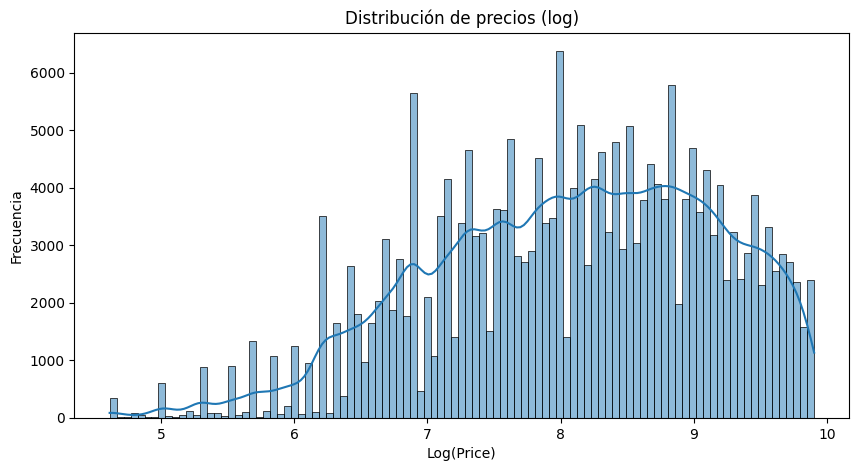

In [35]:
#Distribución. Variable objetivo 'price'
log_price = np.log1p(df_new_filt['price'])

plt.figure(figsize=(10, 5))
sns.histplot(log_price, kde=True)
plt.title('Distribución de precios (log)')
plt.xlabel('Log(Price)')
plt.ylabel('Frecuencia')
plt.show()

Se empleó el logaritmo natural después de sumar 1, siendo que esto es útil para reducir la asimetría en la distribución, debido más que todo a la posible existencia de una distribución sesgada a la derecha, o sea, muchos valores pequeños y pocos valores muy altos.

Se observa por la línea azul, además, que la estimación de la densidad en la distribución se aproxima o es bastante cercana a la distribución normal, siendo ideal para algoritmos de aprendizaje automático que asumen la normalidad en las variables de entrada y salida.

In [36]:
#Resumen de estadística descriptiva del precio original respecto a la transformación
#Estadísticas descriptivas del precio original
original_price = df_new_filt['price'].describe()

#Estadísticas descriptivas del precio transformado
log_price_stats = log_price.describe()

print("Estadísticas descriptivas del precio original:")
print(original_price)

print("\nEstadísticas descriptivas del precio transformado (log):")
print(log_price_stats)

Estadísticas descriptivas del precio original:
count    228568.000000
mean       5159.774303
std        4696.000890
min         100.000000
25%        1500.000000
50%        3500.000000
75%        7500.000000
max       20000.000000
Name: price, dtype: float64

Estadísticas descriptivas del precio transformado (log):
count    228568.000000
mean          8.077030
std           1.060740
min           4.615121
25%           7.313887
50%           8.160804
75%           8.922792
max           9.903538
Name: price, dtype: float64


**Precio Original**

- Media: El precio promedio de los autos es de $5159.78

- Desviación estándar: Hay una dispersión de $4696.01, lo que indica una gran variabilidad en los precios.

- Mínimo y máximo: Los precios varían entre $100 y $20,000

- Cuartiles (25%, 50%, 75%):
    - 25% tienen un precio menor a $1500.
    - La mediana (50%) es $3500, por lo que la mitad de los autos cuestan menos de eso.
    - El 75% cuestan menos de $7500, indicando que hay autos significativamente más caros que sesgan la distribución hacia la derecha.

Básicamente, la distribución del precio original es asimétrica, probablemente sesgada hacia valores más altos.

**Precio Transformado (Log)**

- Media: El promedio en la escala logarítmica es 8.08, lo que corresponde a un precio de aproximadamente $3200 cuando se destransforma (𝑒^8.08 - 1)

- Desviación estándar: La variabilidad es menor (1.06), indicando que la transformación logarítmica reduce la dispersión.

- Mínimo y máximo: El valor mínimo transformado es 4.62 (𝑒^4.62 − 1 ≈ 100), coincidiendo con el precio mínimo original. Y el máximo es 9.90 (𝑒^9.90 − 1 ≈ 20000), coincidiendo también.

- Cuartiles:
    - 25%: 7.31 (𝑒^7.31 − 1 ≈ 1500)
    - Mediana: 8.16 (𝑒^8.16 − 1 ≈ 3500)
    - 75%: 8.92 (𝑒^8.92 − 1 ≈ 7500)

Tras la transformación a escala logarítmica se ajusta la distribución para que sea menos sesgada y más simétrica, haciendo más fácil modelar los datos en caso de programar un modelo lineal.

El impacto de la transformación no altera los valores extremos, pero comprime la escala y reduce el efecto de los valores muy altos. Esto es útil para métodos que suponen distribuciones más simétricas o normalizadas.
Se podría trabajar con el logaritmo de los precios para mejorar los resultados predictivos al reducir el sesgo y la dispersión en los datos.

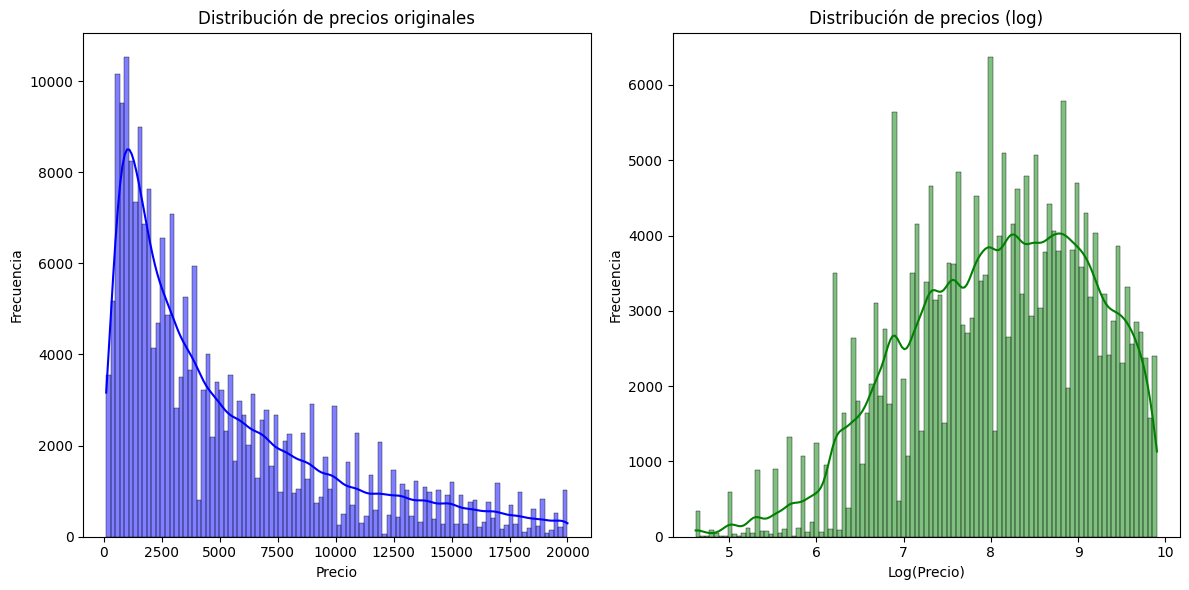

In [37]:
plt.figure(figsize=(12, 6))

#precio original
plt.subplot(1, 2, 1)
sns.histplot(df_new_filt['price'], kde=True, color='blue')
plt.title('Distribución de precios originales')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')

#Precio transformado (log)
plt.subplot(1, 2, 2)
sns.histplot(log_price, kde=True, color='green')
plt.title('Distribución de precios (log)')
plt.xlabel('Log(Precio)')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

Las visualizaciones refuerzan las conclusiones previas:

**Gráfica de precios originales (azul)**
- Forma de la distribución:
    Notablemente sesgada a la derecha, con gran concentración de autos en los precios (media) más bajos (cerca de 0-5000).

    Los valores más altos están extendidos hacia la derecha.

- Interpretación de patrones:
    El sesgo puede dificultar los análisis estadísticos o la capacidad de un modelo para capturar relaciones debido a que dominan los precios bajos.


**Gráfica del logaritmo de precios (verde)**
- Forma de la distribución:
    La distribución se ve más simétrica y parecida a una distribución normal.

    Se han comprimido los valores extremos, facilitando así una interpretación más clara de los patrones subyacentes.

- KDE más informativo:
    La curva de densidad se ajusta mejor a los datos, mostrando una distribución más balanceada.

Como interpretación final en este punto, se podría decir que:

1.- Posible razón para usar logaritmo: Elimina el sesgo y mejora la escalabilidad para modelos de aprendizaje automático.

2.- Modelado: Si se construye un modelo de predicción para los precios, como lo desea Rusty Bargain, trabajar con el logaritmo permitirá que las predicciones sean más precisas, ya que los valores extremos no dominan tanto los cálculos. En dado caso de ser así, se debe recordar revertir la transformación logarítmica para la interpretación de la precicción en escala original.

In [38]:
#Relación: Precio/categóricas
for col in categorical_columns:
    mean_price = df_new_filt.groupby(col)['price'].mean().sort_values(ascending=False)
    print(f'Precio promedio por {col}:\n', mean_price)

Precio promedio por vehicle_type:
 vehicle_type
suv            9455.682686
convertible    7372.845314
coupe          6771.133304
bus            5809.259870
wagon          5411.264708
sedan          5112.306585
other          4201.264037
small          3126.231183
Name: price, dtype: float64
Precio promedio por fuel_type:
 fuel_type
hybrid      10121.421687
electric     9445.727273
gasoline     5170.382532
cng          4719.963680
other        4587.212121
lpg          4265.779704
Name: price, dtype: float64
Precio promedio por gearbox:
 gearbox
auto      7434.420599
manual    4573.221473
Name: price, dtype: float64
Precio promedio por not_repaired:
 not_repaired
no     5541.318038
yes    2209.817550
Name: price, dtype: float64
Precio promedio por brand:
 brand
porsche          12699.796477
mini              9391.912871
land_rover        9379.734908
jeep              7776.037815
jaguar            7366.183844
audi              7099.810797
bmw               6956.708332
mercedes_benz     65

/tmp/ipykernel_186195/2986614196.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_price_df, x=col, y='price', palette='viridis')


<Figure size 1200x600 with 0 Axes>

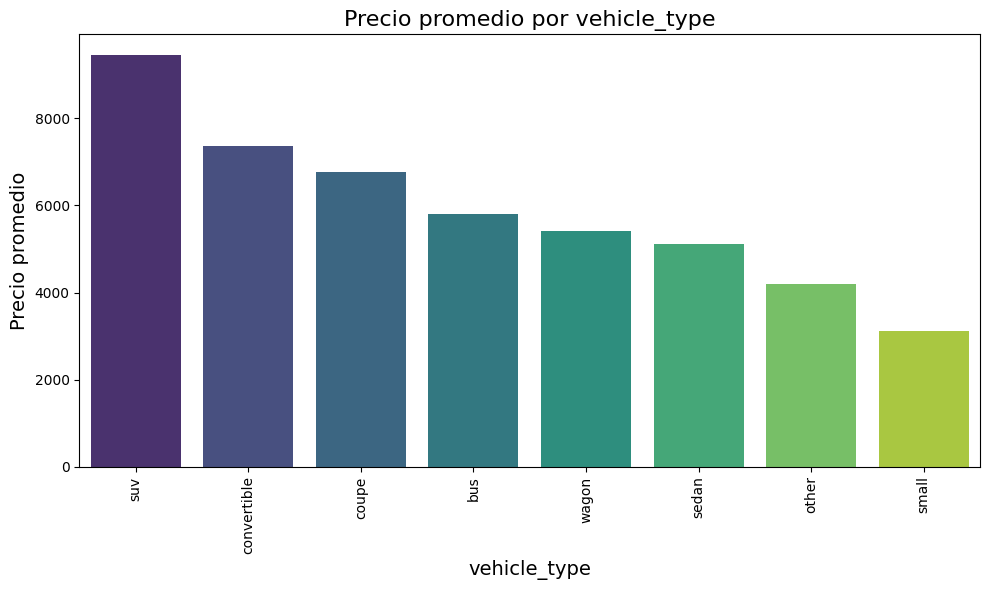

/tmp/ipykernel_186195/2986614196.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_price_df, x=col, y='price', palette='viridis')


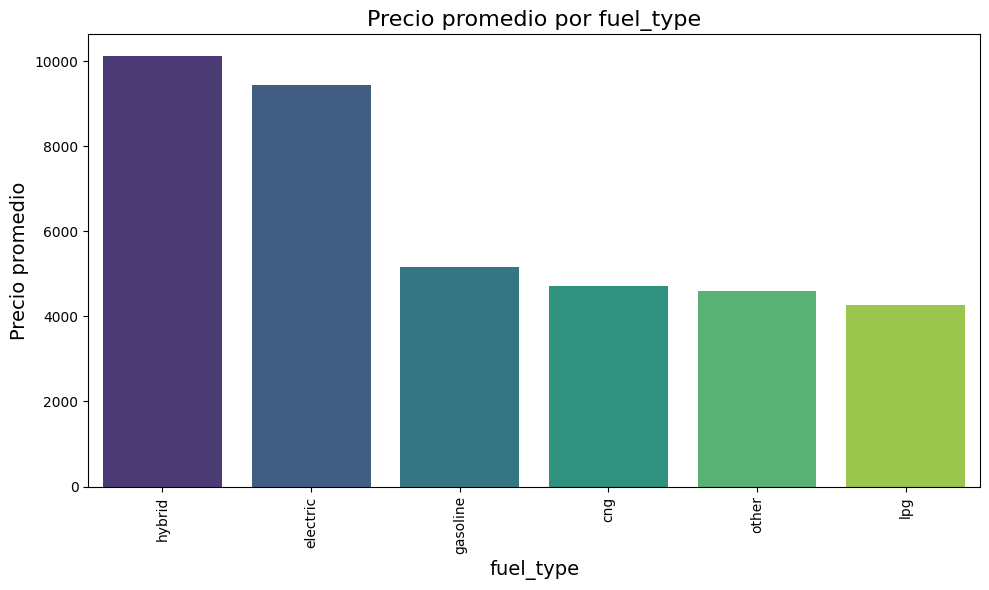

/tmp/ipykernel_186195/2986614196.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_price_df, x=col, y='price', palette='viridis')


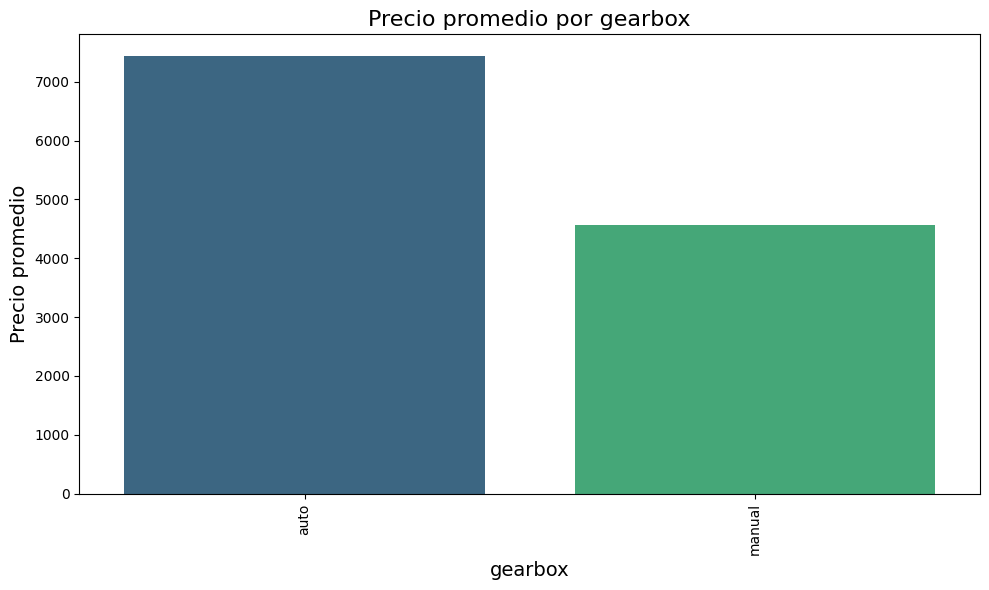

/tmp/ipykernel_186195/2986614196.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_price_df, x=col, y='price', palette='viridis')


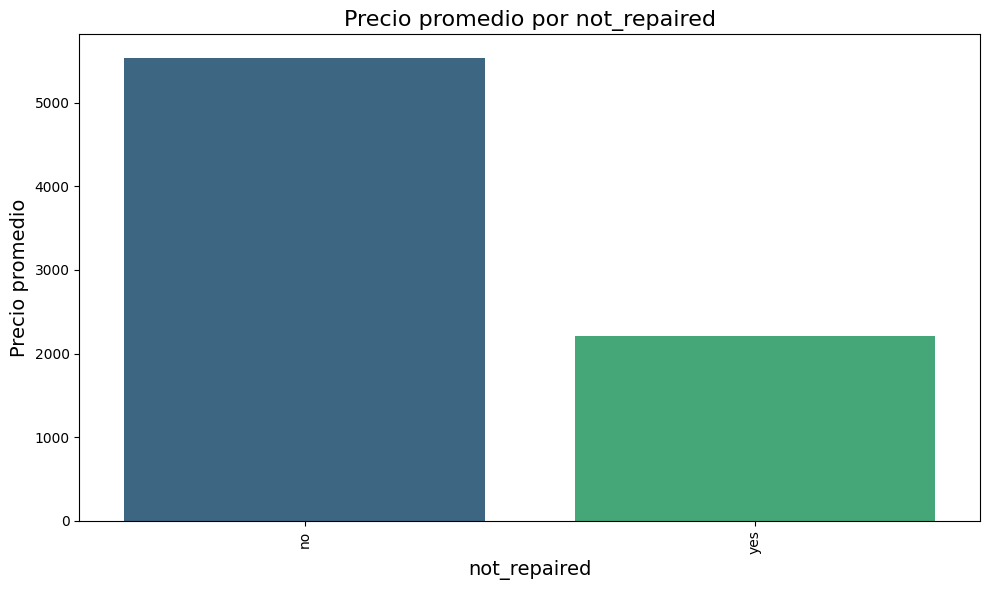

/tmp/ipykernel_186195/2986614196.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_price_df, x=col, y='price', palette='viridis')


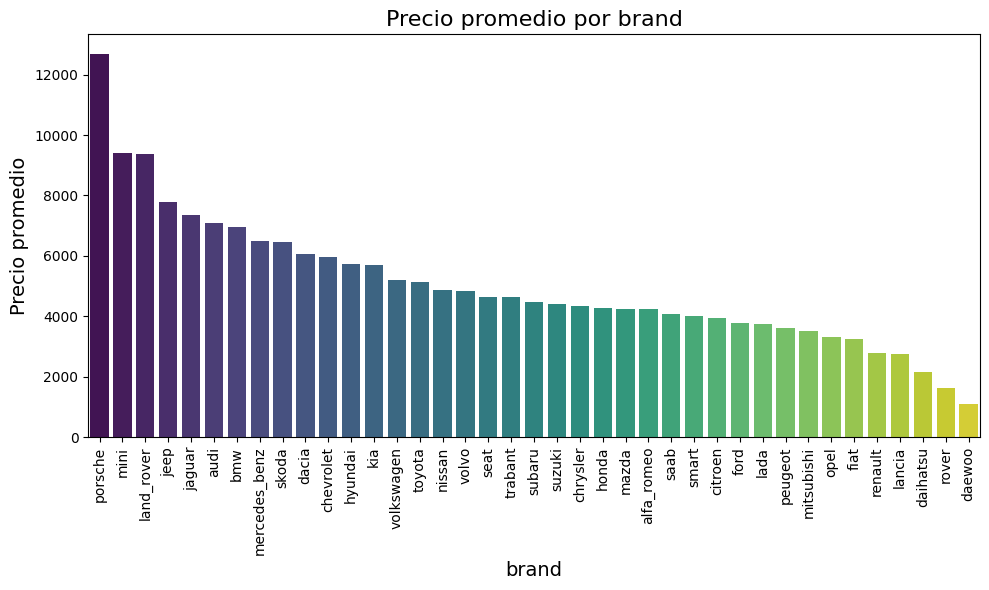

In [39]:
plt.figure(figsize=(12, 6))

for col in categorical_columns:
    mean_price = df_new_filt.groupby(col)['price'].mean().sort_values(ascending=False)
    mean_price_df = mean_price.reset_index()

    plt.figure(figsize=(10, 6))
    sns.barplot(data=mean_price_df, x=col, y='price', palette='viridis')

    plt.title(f'Precio promedio por {col}', fontsize=16)
    plt.xlabel(col, fontsize=14)
    plt.ylabel('Precio promedio', fontsize=14)
    plt.xticks(rotation=90)

    plt.tight_layout()
    plt.show()


/tmp/ipykernel_186195/1101042445.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_new_filt, x=col, y='price', palette='viridis')


<Figure size 1200x600 with 0 Axes>

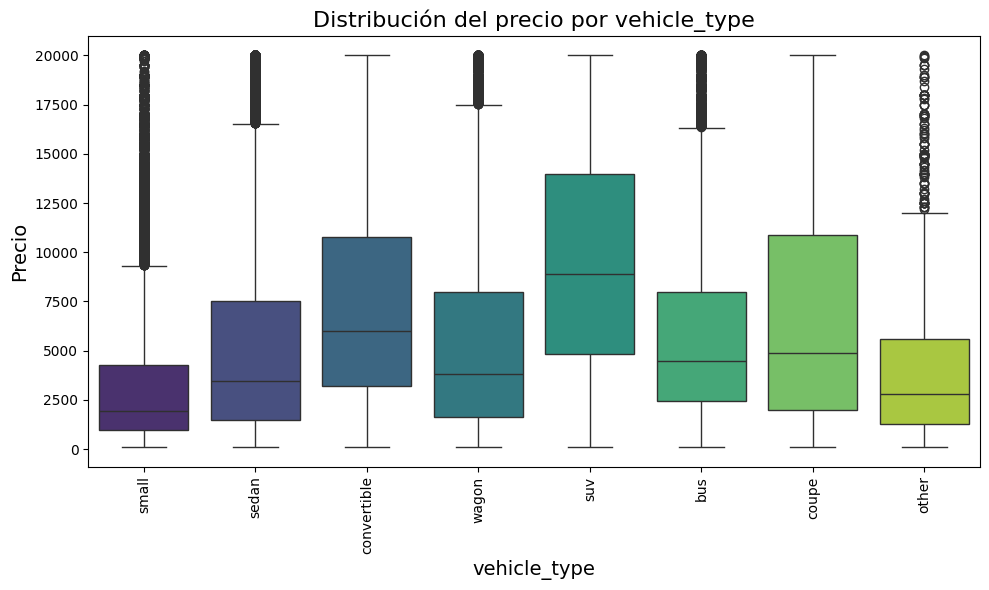

/tmp/ipykernel_186195/1101042445.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_new_filt, x=col, y='price', palette='viridis')


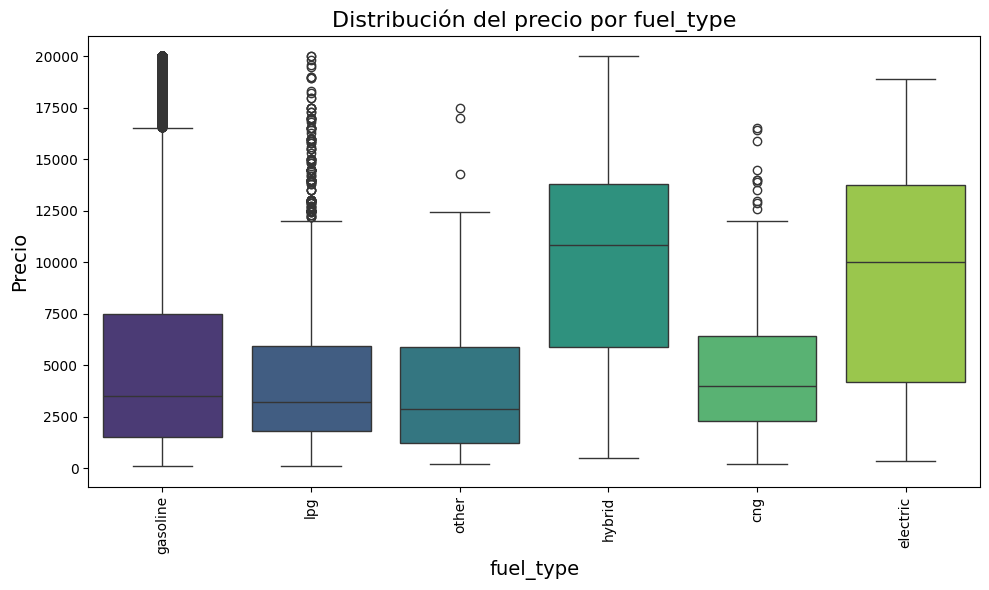

/tmp/ipykernel_186195/1101042445.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_new_filt, x=col, y='price', palette='viridis')


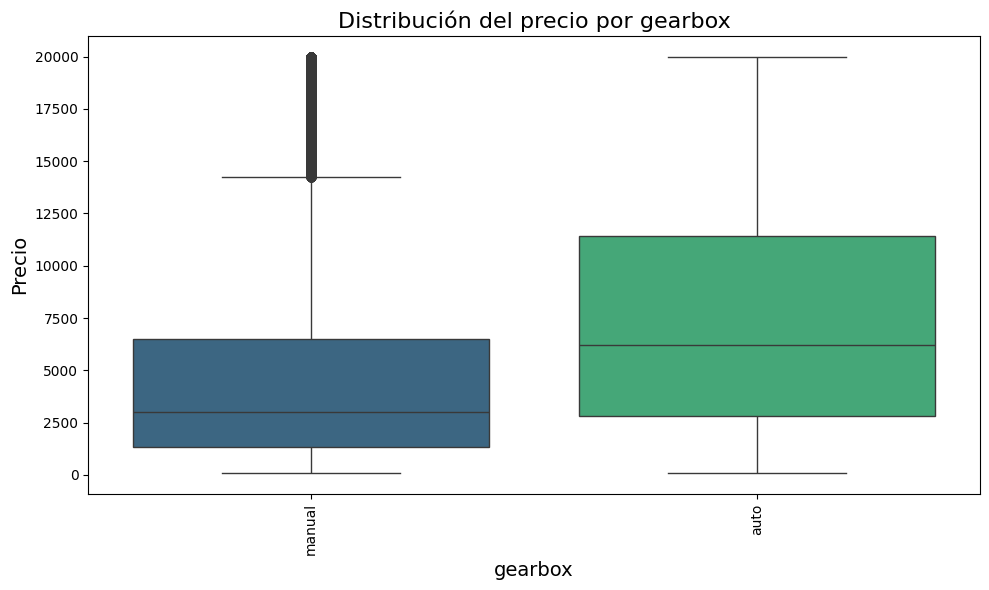

/tmp/ipykernel_186195/1101042445.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_new_filt, x=col, y='price', palette='viridis')


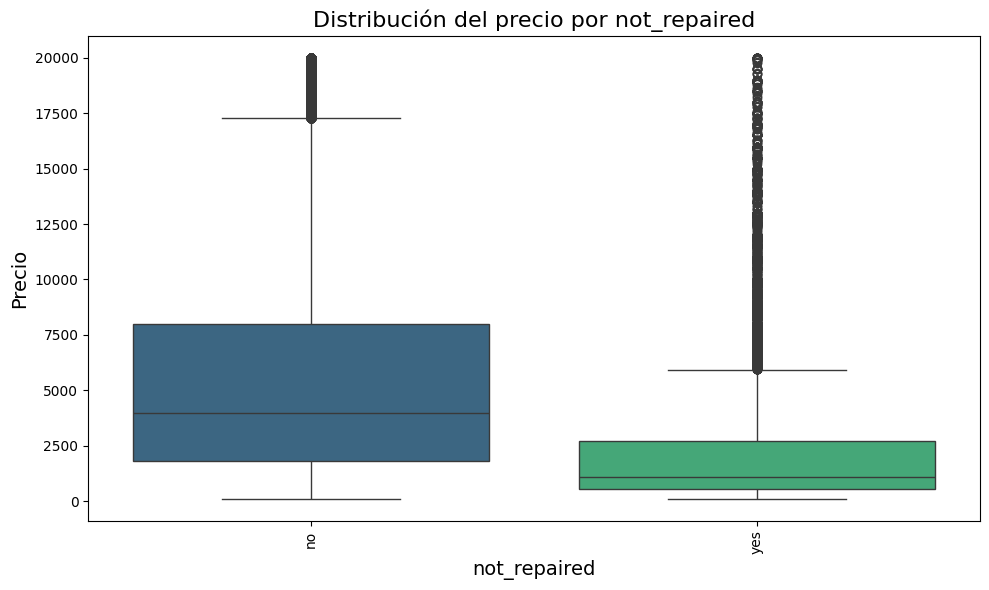

/tmp/ipykernel_186195/1101042445.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_new_filt, x=col, y='price', palette='viridis')


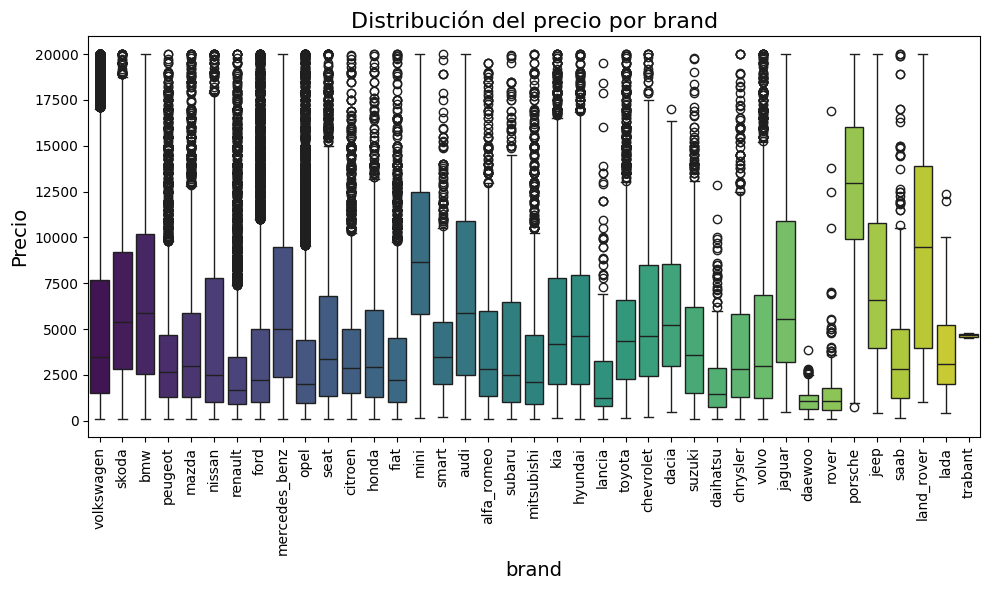

In [40]:
plt.figure(figsize=(12, 6))

for col in categorical_columns:
    #gráfico de cajas
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_new_filt, x=col, y='price', palette='viridis')
    plt.title(f'Distribución del precio por {col}', fontsize=16)
    plt.xlabel(col, fontsize=14)
    plt.ylabel('Precio', fontsize=14)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


In [41]:
#Observo correlación
numeric_df = df_new_filt.select_dtypes(include=[float, int])
print(numeric_df.corr())

                       price  registration_year     power   mileage  \
price               1.000000           0.485073  0.435873 -0.400043   
registration_year   0.485073           1.000000  0.080923 -0.334778   
power               0.435873           0.080923  1.000000  0.101538   
mileage            -0.400043          -0.334778  0.101538  1.000000   
registration_month  0.011892          -0.002466  0.017384  0.006372   

                    registration_month  
price                         0.011892  
registration_year            -0.002466  
power                         0.017384  
mileage                       0.006372  
registration_month            1.000000  


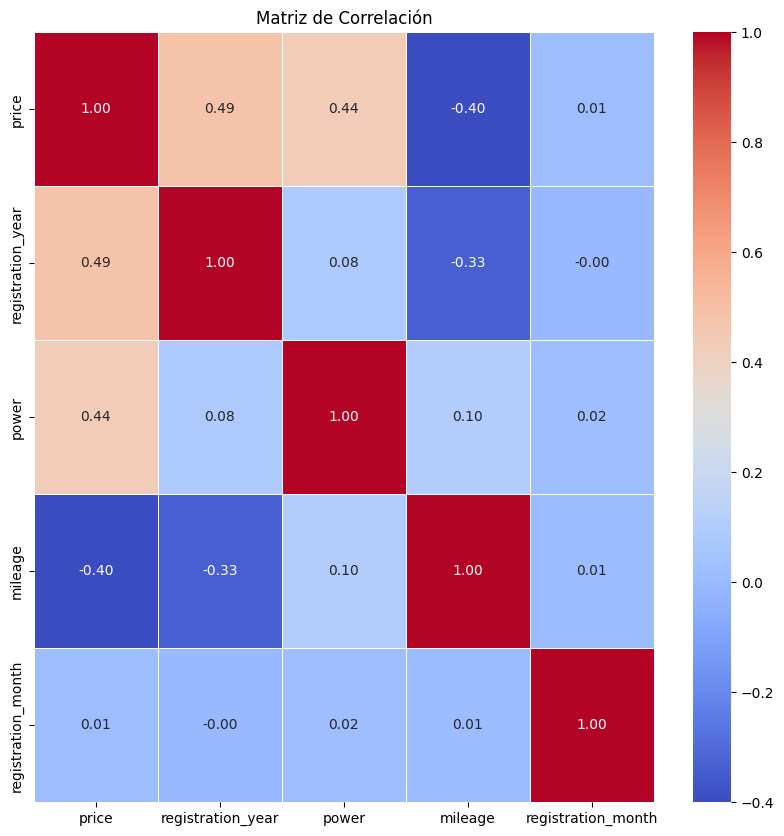

In [42]:
#Graficamos
correlation_matrix = numeric_df.corr()

#Configuramos el tamaño de la figura
plt.figure(figsize=(10, 10))

#heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title("Matriz de Correlación")
plt.show()

De la correlación se ha obtenido lo siguiente:
- Precio (price): 
    - respecto a año de registo (registration_year): correlación positiva, es decir, mientras más nuevo el vehiculo que ha sido registrado, más alto será su precio.
    - respecto a potencia (power): positiva. Coche con mayor potencia tiende a ser más costoso.
    - respecto a kilometraje (mileage): correlación negativa. Mientras más recorrido tenga el auto más económico será el mismo.

- Año de registro (registration_year):
    - respecto a potencia (power): Correlación muy débil. Indica que no hay relación respecto a esta característica.
    - respecto a kilometraje (mileage): negativa. Sugiere que los vehiculos más antiguos RESPECTO AL AÑO DE REGISTRO MENOS RECIENTE tiende a tener mayor kilometraje.

## Ingeniería de Características

Antes de pasar a entrenar el modelo, se procederá a realizar ingeniería de características para crear features adicionales que permitan enriquecer el Dataset ya filtrado y, en consecuencia, obtener un modelo de aprendizaje más robusto que prediga el valor en el mercado del vehiculo. Estas característica tendrán como finalidad: 

- Almacenar la antigüedad de cada vehiculo.
- La cantidad de kilometraje (nivel de uso en términos de distancia recorrida) por año.

Métricas que pueden convenir para obtener un mejor modelo.

In [43]:
actual_year = 2024
df_new_filt['vehicle_age'] = actual_year - df_new_filt['registration_year']
df_new_filt.rename(columns={'registration_year' : 'vehicle_age'})
print(df_new_filt)
print()
print(df_new_filt['vehicle_age'].describe())

        price vehicle_type  registration_year gearbox  power        model  \
0        1500        small               2001  manual   75.0         golf   
1        3600        small               2008  manual   69.0        fabia   
2         650        sedan               1995  manual  102.0          3er   
3        2200  convertible               2004  manual  109.0      2_reihe   
4        2000        sedan               2004  manual  105.0      3_reihe   
...       ...          ...                ...     ...    ...          ...   
228563   7900        sedan               2010  manual  140.0         golf   
228564   5250        wagon               2016    auto  150.0          159   
228565   3200        sedan               2004  manual  225.0         leon   
228566   1199  convertible               2000    auto  101.0       fortwo   
228567   9200          bus               1996  manual  102.0  transporter   

        mileage  registration_month fuel_type       brand not_repaired  \
0

In [44]:
#vehicle_age es igual al máximo encontrado
max_age = df_new_filt['vehicle_age'].max()
outliers = df_new_filt[df_new_filt['vehicle_age'] == max_age]
print(outliers)

       price vehicle_type  registration_year gearbox  power   model  mileage  \
43277   3400        small               1910  manual   90.0  beetle    90000   

       registration_month fuel_type       brand not_repaired  vehicle_age  
43277                   4  gasoline  volkswagen           no          114  


Se observa que la media de la edad de los vehiculos ronda los 20 años, es decir, la mayoría de los automoviles que se suben a la pagina de Rusty Bargain o que aquí se ofertan, tienden a ser de alrededor de 20 años de antigüedad o uso. Para el vehiculo menos antiguo se tiene que posee 5 años de antigüedad, mientras que para el vehiculo más antiguo de todos se tiene un máximo de 114 años, cosa que es bastante rara ya que al observar el año bajo el cual se ha registrado el vehiculo (1910), podemos inferir que pudo haber existido algún error humano o problemas en la extracción de los datos de tal vehiculo, pues el Volkswagen Beetle más antiguo posible data de la década de 1930, año en el que empezo a producirse para ser posteriormente lanzado al mercado en 1938, por lo que se ha de tener en consideración datos de este tipo que puedan afectar demasiado a nuestro modelo de entrenamiento.

In [45]:
#Elimino al ser un dato practicamente superfluo en nuestro análisis
df_new_filt = df_new_filt[df_new_filt['vehicle_age'] != 114]
df_new_filt.reset_index(drop=True, inplace=True)
print(df_new_filt.loc[df_new_filt['vehicle_age'] == 114])#observamos que se haya eliminado
print(df_new_filt['vehicle_age'].describe())

Empty DataFrame
Columns: [price, vehicle_type, registration_year, gearbox, power, model, mileage, registration_month, fuel_type, brand, not_repaired, vehicle_age]
Index: []
count    228567.000000
mean         20.467189
std           6.412675
min           5.000000
25%          16.000000
50%          20.000000
75%          25.000000
max          87.000000
Name: vehicle_age, dtype: float64


Ahora que se ha eliminado tal dato, se observa que el dataset actualizado posee mejor coherencia respecto al auto más antiguo (87 años), por lo que hecha tal modificación ahora se puede proceder con más seguridad para crear la nueva característica del dataset, esto es: el kilometraje por año de los vehiculos.

In [46]:
if 'mileage' in df_new.columns:
    df_new_filt['mileage_per_year'] = df_new_filt['mileage'] / df_new_filt['vehicle_age']

print(df_new_filt)
print()
print(df_new_filt['mileage_per_year'].describe())

        price vehicle_type  registration_year gearbox  power        model  \
0        1500        small               2001  manual   75.0         golf   
1        3600        small               2008  manual   69.0        fabia   
2         650        sedan               1995  manual  102.0          3er   
3        2200  convertible               2004  manual  109.0      2_reihe   
4        2000        sedan               2004  manual  105.0      3_reihe   
...       ...          ...                ...     ...    ...          ...   
228562   7900        sedan               2010  manual  140.0         golf   
228563   5250        wagon               2016    auto  150.0          159   
228564   3200        sedan               2004  manual  225.0         leon   
228565   1199  convertible               2000    auto  101.0       fortwo   
228566   9200          bus               1996  manual  102.0  transporter   

        mileage  registration_month fuel_type       brand not_repaired  \
0

In [47]:
#Último ajuste
df_new_filt = df_new_filt.drop(['registration_month'], axis=1)
#observo cambios
print(df_new_filt.columns)

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'mileage', 'fuel_type', 'brand', 'not_repaired', 'vehicle_age',
       'mileage_per_year'],
      dtype='object')


In [48]:
#última mirada a las estadísticas descriptivas del dataset final
print(df_new_filt.describe())

               price  registration_year          power        mileage  \
count  228567.000000      228567.000000  228567.000000  228567.000000   
mean     5159.782003        2003.532811     123.038724  127454.969440   
std      4696.009720           6.412675      60.895435   36866.966163   
min       100.000000        1937.000000      45.000000    5000.000000   
25%      1500.000000        1999.000000      80.000000  125000.000000   
50%      3500.000000        2004.000000     115.000000  150000.000000   
75%      7500.000000        2008.000000     150.000000  150000.000000   
max     20000.000000        2019.000000    2000.000000  150000.000000   

         vehicle_age  mileage_per_year  
count  228567.000000     228567.000000  
mean       20.467189       6716.090200  
std         6.412675       3181.760385  
min         5.000000         57.471264  
25%        16.000000       5208.333333  
50%        20.000000       6250.000000  
75%        25.000000       7692.307692  
max        87.

## Entrenamiento del Modelo 

In [49]:
#Codificación y Escalado
categorical_cols = ['vehicle_type', 'gearbox', 'fuel_type', 'brand', 'model', 'not_repaired']
numerical_cols = ['power', 'mileage', 'vehicle_age']

#Asigno a variable que luego será usada
df_new_filt_OHE = df_new_filt.copy()

# Separar columnas con pocas categorías
low_cardinality_cols = ['vehicle_type', 'gearbox', 'fuel_type', 'not_repaired']
high_cardinality_cols = ['brand', 'model']

#Aplicar One-Hot Encoding con prefijos
encoder = OneHotEncoder(sparse_output=False, drop='first')
ohe_encoded = encoder.fit_transform(df_new_filt_OHE[low_cardinality_cols])

#Generar nombres de columnas con prefijos claros
ohe_column_names = [f"{col}_{cat}" for col, categories in zip(low_cardinality_cols, encoder.categories_)
                    for cat in categories[1:]]  # Excluye la primera categoría por 'drop=first'

#Crear DataFrame con nombres ajustados
ohe_df = pd.DataFrame(ohe_encoded, columns=ohe_column_names)

#Reemplazar y concatenar con nombres personalizados
df_new_filt_OHE = df_new_filt_OHE.drop(low_cardinality_cols, axis=1)
df_new_filt_OHE = pd.concat([df_new_filt_OHE, ohe_df], axis=1)

#Codificar por frecuencia para columnas con alta cardinalidad
for col in high_cardinality_cols:
    freq_encoding = df_new_filt_OHE[col].value_counts() / len(df_new_filt_OHE)
    df_new_filt_OHE[col] = df_new_filt_OHE[col].map(freq_encoding)

#Escalar características numéricas
scaler = StandardScaler()
df_new_filt_OHE[numerical_cols] = scaler.fit_transform(df_new_filt_OHE[numerical_cols])

print('Luego de codificación híbrida y escalado:')
print(df_new_filt_OHE.head())

Luego de codificación híbrida y escalado:
   price  registration_year     power     model   mileage     brand  \
0   1500               2001 -0.788874  0.084693  0.611525  0.212253   
1   3600               2008 -0.887404  0.006956 -1.015952  0.018025   
2    650               1995 -0.345490  0.060144  0.611525  0.109591   
3   2200               2004 -0.230539  0.015540  0.611525  0.031505   
4   2000               2004 -0.296225  0.010798  0.611525  0.016446   

   vehicle_age  mileage_per_year  vehicle_type_convertible  \
0     0.394970       6521.739130                       0.0   
1    -0.696620       5625.000000                       0.0   
2     1.330619       5172.413793                       0.0   
3    -0.072854       7500.000000                       1.0   
4    -0.072854       7500.000000                       0.0   

   vehicle_type_coupe  ...  vehicle_type_small  vehicle_type_suv  \
0                 0.0  ...                 1.0               0.0   
1                 0.0 

In [50]:
#Características y Objetivo
#Dividiendo el Dataset y verificando conjunto
X = df_new_filt_OHE.drop('price', axis=1)
y = df_new_filt_OHE['price']

#entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12345)

#verificando forma
print(X_train.shape, X_test.shape)

(171425, 21) (57142, 21)


### Regresión Lineal

In [51]:
lr_model = LinearRegression()
%time lr_model.fit(X_train, y_train)#comando para medir tiempo de ejecución en toda la celda
%time lr_predict = lr_model.predict(X_test)
lr_rmse = mean_squared_error(y_test, lr_predict)**0.5
print(f'RMSE de Regresión Lineal: {lr_rmse}')

CPU times: user 332 ms, sys: 13 ms, total: 345 ms
Wall time: 129 ms
CPU times: user 51 ms, sys: 209 μs, total: 51.2 ms
Wall time: 4.21 ms
RMSE de Regresión Lineal: 3072.7457122365595


La regresión lineal ha devuelto un RMSE de 3152, siendo está la prueba de cordura y sierviendo como valor base para comparar los otros modelos y métodos de potenciación de gradiente. Necesitamos menos que lo arrojado en esta prueba de cordura.

### Árbol de Decisión

Se empleará librería GridsearchCV para obtener lo mejores hiperparametros, luego se entrenará el modelo para finalizar con la medición del tiempo de entrenamiento y prueba según las instrucciones indicadas en el proyecto.

In [52]:
#hiperparámetros de árbol de decisión
dt_params = {
    'max_depth': [1, 2, 3, 4, 5, 6] ,
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [2, 4, 6, 8],
}

#GridSearchCV e hiperparámetros establecidos.
#Metríca y valor para validación cruzada
dt_grid = GridSearchCV(
    estimator=DecisionTreeRegressor(),
    param_grid=dt_params,
    scoring='neg_root_mean_squared_error',
    cv=3)

In [53]:
#entrenamos para encontrar mejores hiperparametros
dt_grid.fit(X_train, y_train)
#Buscamos mejores hiperparametros que devuelven más bajo RSME
max_score = dt_grid.cv_results_['mean_test_score'].max()
index_max_score = np.where(dt_grid.cv_results_['mean_test_score'] == max_score)[0][0]

best_set_of_params = dt_grid.cv_results_['params'][index_max_score]
print(f'Hiperparámetros recomendados: {best_set_of_params} | Mejor RSME: {-max_score}')

KeyboardInterrupt: 

In [ ]:
#Entrenamiento de modelo
dt_model = DecisionTreeRegressor(random_state=12345, max_depth=6, min_samples_split=2, min_samples_leaf=2)
%time dt_model.fit(X_train, y_train)
%time dt_predict = dt_model.predict(X_test)
dt_rmse = mean_squared_error(y_test, dt_predict)**0.5
print(f'RMSE de Árbol de Decisión: {dt_rmse}')

CPU times: user 356 ms, sys: 0 ns, total: 356 ms
Wall time: 354 ms
CPU times: user 8.88 ms, sys: 0 ns, total: 8.88 ms
Wall time: 8.85 ms
RMSE de Árbol de Decisión: 2335.584352047637


Una vez ajustados los hiperparametros más óptimos según lo calculado, se observa un RSME más inferior (2328.080) respecto a la prueba de cordura (regresión lineal=3152), indicando que nos encontramos en buen camino para hallar el mejor modelo.

Se tiene los siguientes tiempos:
- Entrenamiento: 
    - CPU times: user 307 ms, 
    - sys: 0 ns, 
    - total: 307 ms
    - Wall time: 305 ms
- Predicción:
    - CPU times: user 7.42 ms
    - sys: 0 ns
    - total: 7.42 ms 
    - Wall time: 7.11 ms

### Bosque Aleatorio

Al igual que 'árbol de decisión', se empleará librería GridsearchCV para obtener lo mejores hiperparametros y luego entrenar nuestro modelo.

In [ ]:
rf_params = {
    'n_estimators' : [10, 20, 40],
    'max_depth': [1, 2, 3, 4, 5, 6] 
}

rf_grid = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid=rf_params,
    scoring='neg_root_mean_squared_error',
    cv=3)

In [ ]:
#entrenamos para encontrar mejores hiperparametros
rf_grid.fit(X_train, y_train)
#Buscamos mejores hiperparametros que devuelven más bajo RSME
max_score = rf_grid.cv_results_["mean_test_score"].max()
index_max_score = np.where(rf_grid.cv_results_["mean_test_score"] == max_score)[0][0]

best_set_of_params = rf_grid.cv_results_["params"][index_max_score]

print(f'Hiperparámetros recomendados: {best_set_of_params} | Mejor RSME: {-max_score}')

Hiperparámetros recomendados: {'max_depth': 6, 'n_estimators': 40} | Mejor RSME: 2269.914174881939


In [ ]:
#Entrenamiento de modelo
rf_model = RandomForestRegressor(random_state=12345, max_depth=6, n_estimators=20)
%time rf_model.fit(X_train, y_train)
%time rf_predict = rf_model.predict(X_test)
rf_rmse = mean_squared_error(y_test, rf_predict)**0.5
print(f'RMSE de Bosque Aleatorio: {rf_rmse}')

CPU times: user 5.34 s, sys: 0 ns, total: 5.34 s
Wall time: 5.34 s
CPU times: user 46.1 ms, sys: 0 ns, total: 46.1 ms
Wall time: 46 ms
RMSE de Bosque Aleatorio: 2262.5691849992604


Una vez ajustados los hiperparametros más óptimos según lo calculado, se observa un RSME un poco más inferior (2259.878) al modelo anterior (2328.080), cumpliendo así con la mejora del mismo. Cabe acotar que, a dicho resultado se ha de considerar el tiempo de entrenamiento para nuestro modelo, pues el mismo resulto ser mucho más alto que el anterior, por lo que podría inferirse que, dada la mejora teniendo en cuenta el tiempo de entrenamiento del modelo, el mismo no resulta ser demasiado eficiente  considerando esto por su infima mejora del RSME que presenta respecto al Árbol de Regresión.

Se tiene los siguientes tiempos:
- Entrenamiento: 
    - CPU times: user 4.39 s
    - sys: 3.34 ms, 
    - total: 4.39 s 
    - Wall time: 4.39 s
- Predicción:
    - CPU times: user 78.1 ms
    - sys: 0 ns
    - total: 78.1 ms
    - Wall time: 77.8 ms

### Catboost

Empleando el método de potenciación de gradiente CatBoost para mejorar el modelo de aprendizaje. Este algoritmo no requiere que se preprocesen las características categóricas, por lo que no es necesario usar la variable que almacena el DataFrame encodificado OHE.

In [ ]:
#Características y objetivos antes de OHE
features = df_new_filt.drop('price', axis=1)
target = df_new_filt['price']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=12345)

#Selecciono sólo las columnas cuyas características son categóricas
categorical_columns = features_train.select_dtypes(include=['object']).columns.tolist()

#Tipo 'category'
for column in categorical_columns:
    features_train.loc[:, column] = features_train.loc[:, column].astype('category')
    features_test.loc[:, column] = features_test.loc[:, column].astype('category')

#Hiperparámetros a ajustar
cb_params = {
    'depth': [4, 6, 10],
    'learning_rate': [0.1, 0.2, 0.5]
}

#Estimador
cb_est = CatBoostRegressor(iterations=100, cat_features=categorical_columns, verbose=False, loss_function='RMSE')

cb_grid = GridSearchCV(
    estimator=cb_est,
    param_grid=cb_params,
    scoring='neg_root_mean_squared_error',
    cv=3
)

In [ ]:
cb_grid.fit(features_train, target_train)

max_score = cb_grid.cv_results_["mean_test_score"].max()
index_max_score = np.where(cb_grid.cv_results_["mean_test_score"] == max_score)[0][0]

best_params = cb_grid.cv_results_["params"][index_max_score]

print(f'Hiperparámetros recomendados: {best_params} | Mejor RSME: {-max_score}')

Hiperparámetros recomendados: {'depth': 10, 'learning_rate': 0.5} | Mejor RSME: 1629.8317045889482


In [ ]:
cb_model = CatBoostRegressor(random_state=12345, iterations=100, depth=10, learning_rate=0.5, loss_function='RMSE', cat_features=categorical_columns, verbose=False)
%time cb_model.fit(features_train, target_train)
%time cb_predict = cb_model.predict(features_test)
cb_rmse = mean_squared_error(target_test, cb_predict)**0.5
print(f'RMSE de CatBoost: {cb_rmse}')

CPU times: user 21 s, sys: 2.17 s, total: 23.2 s
Wall time: 4.39 s
CPU times: user 87.4 ms, sys: 0 ns, total: 87.4 ms
Wall time: 49.2 ms
RMSE de CatBoost: 1613.1701365892977


Una vez ajustados los hiperparametros más óptimos según lo calculado, se observa un RSME de enorme mejora (1615.380), cumpliendo además con un tiempo de entrenamiento bastante optimo, por lo que, hasta ahora, el modelo de entrenamiento basado en catboost viene siendo el más prometedor, tanto en velocidad como en eficiencia en las predicciones.

Se tiene los siguientes tiempos:
- Entrenamiento: 
    - CPU times: user 21.7 s
    - sys:  47.4 ms, 
    - total: 21.7 s 
    - Wall time: 21.8 s
- Predicción:
    - CPU times: 85.6 ms 
    - sys: 0 ns
    - total: 85.6 ms
    - Wall time: 85.5 ms

### XGBoost

A diferencia de CatBoost, XGBoost requiere previamente un encodificado de características, por lo que tomaremos el conjunto perteneciente a tal encodificado OHE 
ya que sólo acepta características númericas.

In [ ]:
#Hiperparametros
xgb_params = {'max_depth': [4, 6, 8], 
            'n_estimators': [50, 100],
            'learning_rate': [0.05, 0.1],
            'subsample': [0.6, 0.8]
}

xgb_est = XGBRegressor()

xgb_grid = GridSearchCV(estimator=xgb_est, param_grid=xgb_params, scoring='neg_root_mean_squared_error', cv=3)

In [ ]:
"""#Buscamos los mejores hiperparametros
xgb_grid.fit(X_train, y_train)
max_score = xgb_grid.cv_results_["mean_test_score"].max()
index_max_score = np.where(xgb_grid.cv_results_["mean_test_score"] == max_score)[0][0]

best_params = xgb_grid.cv_results_["params"][index_max_score]

print(f'Hiperparámetros recomendados: {best_params} | Mejor RSME: {-max_score}')"""

'#Buscamos los mejores hiperparametros\nxgb_grid.fit(X_train, y_train)\nmax_score = xgb_grid.cv_results_["mean_test_score"].max()\nindex_max_score = np.where(xgb_grid.cv_results_["mean_test_score"] == max_score)[0][0]\n\nbest_params = xgb_grid.cv_results_["params"][index_max_score]\n\nprint(f\'Hiperparámetros recomendados: {best_params} | Mejor RSME: {-max_score}\')'

**NOTA**: El código anterior se ha dejado comentado debido al tiempo requerido de cálculo para hallar los hiperparmaetros más óptimos.

In [ ]:
#Entrenamos modelo con hiperparametros
xgb_model = XGBRegressor(random_state=12345, max_depth=8, n_estimators=100, learning_rate=0.1, subsample=0.8)
%time xgb_model.fit(X_train, y_train)
%time xgb_predict = xgb_model.predict(X_test)
xgb_rmse = mean_squared_error(y_test, xgb_predict)**0.5
print(f'RMSE de XGBoost: {xgb_rmse}')

CPU times: user 9.5 s, sys: 97.8 ms, total: 9.59 s
Wall time: 1.35 s
CPU times: user 246 ms, sys: 0 ns, total: 246 ms
Wall time: 38.5 ms
RMSE de XGBoost: 1616.394883342501


Una vez ajustados los hiperparametros más óptimos según lo calculado, se observa un RSME bastante aceptable (1619) respecto a la prueba de cordura (3155.442) pero no con una mejora respecto a catboost(1615).

Se obtuvo los siguientes tiempos:
- Entrenamiento: 
    - CPU times: user 39.4 s
    - sys: 123 ms
    - total: 39.5 s
    - Wall time: 39.8 s
- Predicción:
    - CPU times: user 429 ms
    - sys: 0 ns
    - total: 429 ms
    - Wall time: 418 ms

### LightGBM

Al igual que CatBoost, puede emplearse sin el preprocesamiento de las características categóricas encodificadas con OHE. Además, es necesario que se transformen previamente las características a tipo int o category.

In [ ]:
#Igual que catboost, tomo el conjunto para antes de OHE
for col in categorical_columns:
    df_new_filt[col] = df_new_filt[col].astype('category')

X_LGBM = df_new_filt.drop('price', axis=1)
y_LGBM = df_new_filt['price']

X_LGBM_train, X_LGBM_test, y_LGBM_train, y_LGBM_test = train_test_split(X_LGBM, y_LGBM, test_size=0.25, random_state=12345)

In [ ]:
LGBM_params = {
    'n_estimators': [100, 150, 300],
    'learning_rate': [0.1, 0.2, 0.5],
    'num_leaves': [10, 20, 30],
    'max_depth': [5, 8, 10],
    'subsample': [0.6, 0.7, 0.8]
}

LGBM_est = LGBMRegressor()

LGBM_grid = GridSearchCV(
    estimator=LGBM_est,
    param_grid=LGBM_params,
    scoring='neg_root_mean_squared_error',
    cv=3  
)

In [ ]:
#Entrenamos para hallar los mejores hiperparametros
"""LGBM_grid.fit(X_LGBM_train, y_LGBM_train)

max_score = LGBM_grid.cv_results_["mean_test_score"].max()
index_max_score = np.where(LGBM_grid.cv_results_["mean_test_score"] == max_score)[0][0]

best_params = LGBM_grid.cv_results_["params"][index_max_score]

print(f'Hiperparámetros recomendados: {best_params} | Mejor RECM: {-max_score}')"""

'LGBM_grid.fit(X_LGBM_train, y_LGBM_train)\n\nmax_score = LGBM_grid.cv_results_["mean_test_score"].max()\nindex_max_score = np.where(LGBM_grid.cv_results_["mean_test_score"] == max_score)[0][0]\n\nbest_params = LGBM_grid.cv_results_["params"][index_max_score]\n\nprint(f\'Hiperparámetros recomendados: {best_params} | Mejor RECM: {-max_score}\')'

**NOTA**: El código anterior se ha dejado comentado debido al tiempo requerido de cálculo para hallar los hiperparametros más óptimos.

In [ ]:
LGBM_model = LGBMRegressor(n_estimators=300, learning_rate=0.2, num_leaves=30, max_depth=10, subsample=0.6, random_state=12345)
%time LGBM_model.fit(X_LGBM_train, y_LGBM_train)
%time LGBM_predict = LGBM_model.predict(X_LGBM_test)
LGBM_rmse = mean_squared_error(y_LGBM_test, LGBM_predict)**0.5
print(f'RMSE de LightGBM: {LGBM_rmse}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008351 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 171425, number of used features: 11
[LightGBM] [Info] Start training from score 5165.105218
CPU times: user 10.1 s, sys: 88.7 ms, total: 10.1 s
Wall time: 1.4 s
CPU times: user 1.4 s, sys: 29 ms, total: 1.43 s
Wall time: 195 ms
RMSE de LightGBM: 1569.4304067409205


Una vez ajustados los hiperparametros más óptimos según lo calculado, se observa un RSME de enorme mejora (1575.539) respecto a la prueba de cordura (2768.90) y, naturalmente, respecto a xgboost (1637.026) y catboost(1615.380). Por lo que, LightGBM pasará a ser nuestro metodo de potenciación de gradiente escogido para construir nuestro modelo.

Se obtuvo los siguientes tiempos:
- Entrenamiento: 
    - CPU times: user 4.95 s
    - sys: 36.9 ms
    - total:  4.99 s
    - Wall time: 4.96 s
- Predicción:
    - CPU times:  1.52 s
    - sys: 0 ns
    - total: 1.52 s
    - Wall time: 1.51 s

## Análisis del modelo

In [ ]:
#Ordenando resultado en un DataFrame para mejor visualización
data_models = {
    'modelo': ['Regresión Lineal', 'Árbol de Decisión', 'Bosque Aleatorio', 'CatBoost', 'XGBoost', 'LightGBM'],
    'tiempo_ajuste_hiperparámetros': [0.0423, 0.307, 4.39, 21.8, 39.4, 4.96],
    'tiempo_de_entrenamiento': [0.0419, 0.305, 4.39, 21.8, 39.8, 4.96],
    'tiempo_de_prueba': [0.0357, 0.0711, 0.0778, 0.0855, 0.418, 1.51],
    'RMSE': [3155.4428640331175, 2328.080497374315, 2259.878030906163, 1615.3803898078384, 1615.4275074653872, 1575.5393829849745]
}

models_table = pd.DataFrame(data_models)

print(models_table)

              modelo  tiempo_ajuste_hiperparámetros  tiempo_de_entrenamiento  \
0   Regresión Lineal                         0.0423                   0.0419   
1  Árbol de Decisión                         0.3070                   0.3050   
2   Bosque Aleatorio                         4.3900                   4.3900   
3           CatBoost                        21.8000                  21.8000   
4            XGBoost                        39.4000                  39.8000   
5           LightGBM                         4.9600                   4.9600   

   tiempo_de_prueba         RMSE  
0            0.0357  3155.442864  
1            0.0711  2328.080497  
2            0.0778  2259.878031  
3            0.0855  1615.380390  
4            0.4180  1615.427507  
5            1.5100  1575.539383  


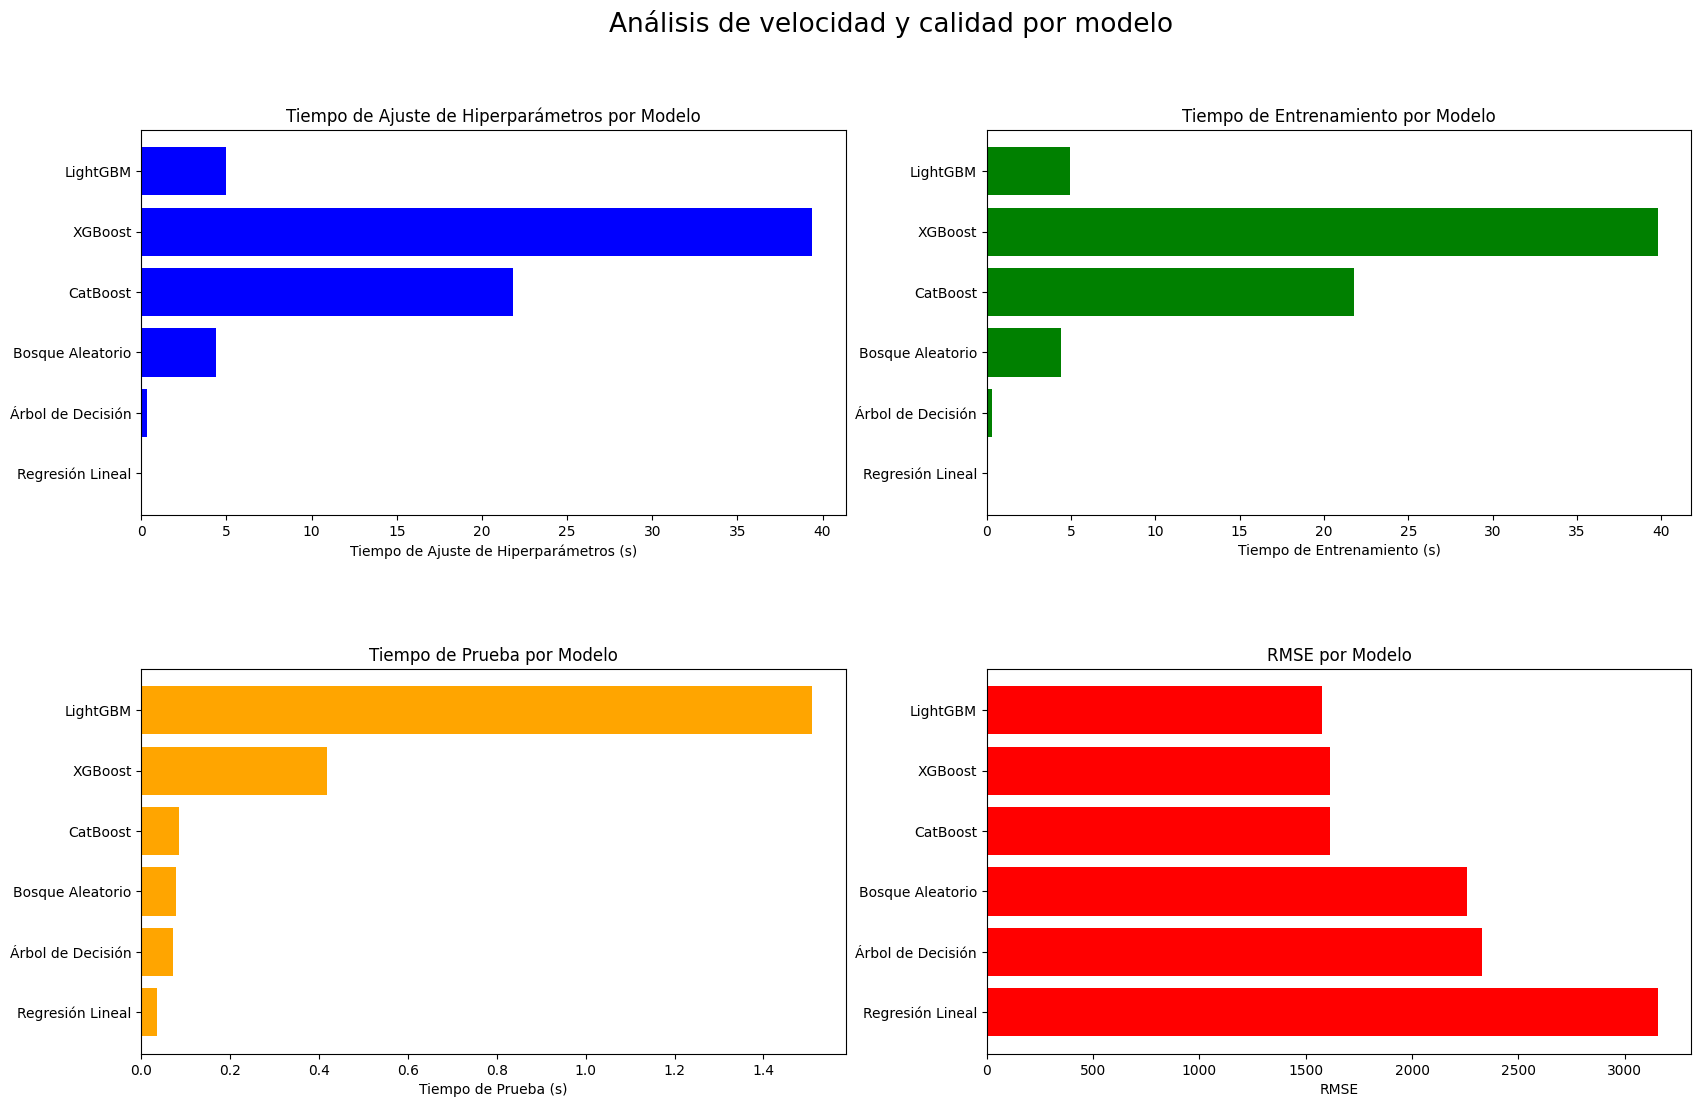

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))
fig.suptitle('Análisis de velocidad y calidad por modelo', fontsize=19)
plt.subplots_adjust(hspace=0.4)

#Gráfico 1: Tiempo de ajuste de hiperparámetros
axs[0, 0].barh(models_table['modelo'], models_table['tiempo_ajuste_hiperparámetros'], color='b')
axs[0, 0].set_xlabel('Tiempo de Ajuste de Hiperparámetros (s)')
axs[0, 0].set_title('Tiempo de Ajuste de Hiperparámetros por Modelo')

#Gráfico 2: Tiempo de entrenamiento
axs[0, 1].barh(models_table['modelo'], models_table['tiempo_de_entrenamiento'], color='g')
axs[0, 1].set_xlabel('Tiempo de Entrenamiento (s)')
axs[0, 1].set_title('Tiempo de Entrenamiento por Modelo')

#Gráfico 3: Tiempo de prueba
axs[1, 0].barh(models_table['modelo'], models_table['tiempo_de_prueba'], color='orange')
axs[1, 0].set_xlabel('Tiempo de Prueba (s)')
axs[1, 0].set_title('Tiempo de Prueba por Modelo')

#Gráfico 4: RMSE
axs[1, 1].barh(models_table['modelo'], models_table['RMSE'], color='r')
axs[1, 1].set_xlabel('RMSE')
axs[1, 1].set_title('RMSE por Modelo')

#Mostrar el gráfico
plt.show()

De lo anterior se deduce que, para el tiempo de ajustes de hiperparametros y entrenamiento, el modelo basado en XGBoost requiere más tiempo y, además, los más veloces son Árbol de Decisión y LightGBM.

Respecto a su tiempo de predicción y RMSE, se observa que, Bosque Aleatorio y Catboost son los más veloces, mientras que LightGBM mostró la mejor precisión de todos los modelos examinados, pues el valor de este fue el más bajo. Modelo a usar: LightGBM

En los ajustes de los hiperparametros se pueden observar, para cada uno de los modelos, diferentes de los mismos, seleccionados para ser los que directamente se ajusten para conseguir la mejor calidad en la construcción de nuestro modelo. Se probaron varios valores para la profundidad de arbol, número mínimo de muestras para dividir nodo interno y muestras requeridas para ser nodo final, además de, por supuesto, en otros modelos observarlo con varias combinaciones de número de árboles en bosque aleatorio al igual que con el hiperparametros de la tasa de aprendizaje (learning_rate), la fracción de muestra a utilizar para entrenar cada árbol y el número de hojas máximo por árbol, siempre especificando que la función de pérdida a usar es rmse. Luego se especifíco neg_root_mean_squared_error para evaluar calidad de combinaciones de hiperparametros. cv es el número de pliegues en validación cruzada. Por último, se emplea un diccionario en conjunto con una clave que proporciona el promedio en el conjunto de prueba para cada combinación de hiperparametros y encuentra el puntaje más alto, extrayendo el primer índice de la lista, encuentra el índice donde el puntaje promedio del conjunto de prueba es igual a la puntuación máxima; todo esto manteniendo coherencia con la división del conjunto de datos test_size=0.25

# CONCLUSIÓN

En la primera parte, se tiene la exploración y el preprocesamiento de datos, donde se abordaron todos los detalles pertinentes al dataset antes de proceder a la evaluación y construcción de nuestro modelo de aprendizaje. Se manejaron valores duplicados y ausentes, eliminando aquellos que no pudieron rellenarse una vez creada y aplicada la función correspondiente para tal tarea. Se filtraro y transformaron los datos átipicos teniendo en cuenta el mercado al que va dirigido el modelo y el cliente que nos ha solicitado tal tarea.

Una vez codificadas y escaladas las características, se impementaron diferentes modelos de regresión al igual que distintas formas de potenciación de gradiente para encontrar el mejor, seguido del ajuste de los hiperparámetros ayudados de GridSearchCV que nos permitió obtener las predicciones más optimas dado ciertos ajustes de los mismos, para por fin, una vez evaluados todos, llegar a la conclusión de que el modelo basado en LightGBM  es el más apropiado y optimo en la utilización de nuestro mmodelo de aprendizaje por arrojar los valores más aceptables, superando con creces a la regresión lineal, árbol de decisión y bosque aleatorio. Por lo que, LightGBM ofrece la mejor combinación en lo solicitado por Bargain (velocidad y calidad) para determinar el valor de mercado de un coche de segunda mano.